In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib.style
plt.style.use("ggplot")
%matplotlib inline
import glob

import sys
sys.version

'3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]'

# 设置商品属性

In [496]:
setup = {
        "T9000":{"commissions_type" : "yuan_per_contract",
                 "commissions":3, #元一手
                 "slippage": 2, #元一手
                 "margin": 0.02,
                 "unit": 10000,
                 "bpv": 1},

        "j9000":{"commissions_type" : "%%",
                 "commissions":0.00006, # 0.6%%
                 "slippage": 2, #元一手
                 "margin": 0.05,
                 "unit": 100,
                 "bpv": 1},

        "au000":{"commissions_type" : "yuan_per_contract",
                 "commissions":10, #元一手
                 "slippage": 2, #元一手
                 "margin": 0.07,
                 "unit": 1000,
                 "bpv": 1},    

        "IC000":{"commissions_type" : "%%",
                 "commissions":0.000023, #0.23%%
                 "slippage": 2, #元一手
                 "margin": 0.08,
                 "unit": 1,
                 "bpv": 200},

        "l9000":{"commissions_type" : "yuan_per_contract",
                 "commissions":2, #元一手
                 "slippage": 2, #元一手
                 "margin": 0.05,
                 "unit": 5,
                 "bpv": 1},

        "m9000":{"commissions_type" : "%%",
                 "commissions":0.00006, # 0.6%%
                 "slippage": 2, #元一手
                 "margin": 0.05,
                 "unit": 10,
                 "bpv": 1},

        "OI000":{"commissions_type" : "yuan_per_contract",
                 "commissions":2, #元一手
                 "slippage": 2, #元一手
                 "margin": 0.05,
                 "unit": 10,
                 "bpv": 1},
                    }

In [484]:
# # 将手续费设为零作为对比组进行回测：

# setup = {
#         "T9000":{"commissions_type" : "yuan_per_contract",
#                  "commissions":0, #元一手
#                  'slippage': 2, #元一手
#                  "margin": 0.02,
#                  "unit": 10000,
#                  "bpv": 1},

#         "j9000":{"commissions_type" : "%%",
#                  "commissions":0, # 0.6%%
#                  'slippage': 2, #元一手
#                  "margin": 0.05,
#                  "unit": 100,
#                  "bpv": 1},

#         "au000":{"commissions_type" : "yuan_per_contract",
#                  "commissions":0, #元一手
#                  'slippage': 2, #元一手
#                  "margin": 0.07,
#                  "unit": 1000,
#                  "bpv": 1},    

#         "IC000":{"commissions_type" : "%%",
#                  "commissions":0, #0.23%%
#                  'slippage': 2, #元一手
#                  "margin": 0.08,
#                  "unit": 1,
#                  "bpv": 200},

#         "l9000":{"commissions_type" : "yuan_per_contract",
#                  "commissions":0, #元一手
#                  'slippage': 2, #元一手
#                  "margin": 0.05,
#                  "unit": 5,
#                  "bpv": 1},

#         "m9000":{"commissions_type" : "%%",
#                  "commissions":0, # 0.6%%
#                  'slippage': 2, #元一手
#                  "margin": 0.05,
#                  "unit": 10,
#                  "bpv": 1},

#         "OI000":{"commissions_type" : "yuan_per_contract",
#                  "commissions":0, #元一手
#                  'slippage': 2, #元一手
#                  "margin": 0.05,
#                  "unit": 10,
#                  "bpv": 1},
#                     }

# 创建所需要的函数

In [576]:
class Models():
    
    def __init__(self):
        print ("Creating ML_Models...")
    ####### Model 1: random_forest #######
    
    # para_1: m_d = max_depth,
    # para_2: m_s_s = min_samples_split,
    # para_3: n_e = n_estimators,
    # para_4: rs = random_state
    def random_forest(self, m_d, m_s_s, n_e, rs):
        rf_model = RandomForestClassifier(
                        max_depth=m_d,
                        min_samples_split=m_s_s,
                        n_estimators=n_e,
                        random_state=rs)
        return rf_model
    
    ####### Model 2: SVM #######
    
    # para_1: C = C,
    # para_2: gamma = gamma,
    # para_3: svm_rs = random_state
    def svm(self, C, gamma, svm_rs):
        svm_model = SVC(C = C, 
                        gamma = gamma, 
                        random_state = svm_rs)
        return svm_model
    
    
def preprocess_df(location, file):
    df = pd.read_csv(location+file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    return df

def preprocess_df_multiplies(file, ticker, price_col):
    df = pd.read_csv(file, engine="python", header=None)
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'open_interests']
    df['margin'] = setup[ticker]['margin']
    df['unit'] = setup[ticker]['unit']
    df['bpv'] = setup[ticker]['bpv']
    df['vals_per_contract_no_lever'] = df[price_col]*df['unit']*df['bpv']
    df['vals_per_contract_using_lever'] = df[price_col]*df['unit']*df['bpv']*df['margin']
    print ('file: ', file)
    print ('start_date: ', df['date'][0])
    print (df.iloc[:3, :])
    return df

# 这个函数主要用来打印和查看数据文件中的细节信息：
def check_files_data_info(location, price_col):
    
    # 储存商品数据文件信息
    info_dict = {
        "ticker": [],
        "start_date": [],
        "max_{}_price".format(price_col): [],
        "max_vals_per_contract_no_lever": [],
        "max_vals_per_contract_using_lever":[]
    }
    
    for file in location:
        # 提取ticker，商品期货代号
        ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
        print ("===================================== Checking ticker {}'s info: =====================================".format(ticker))
        df = preprocess_df_multiplies(file, ticker, price_col)
        # 查看每个商品的数据开始日期
        date = df['date'][0]
        # 查看每个商品数据之中的最大价格
        max_price = df[price_col].max()
        # 查看每个商品数据之中的最大一手无杠杆价值
        max_vals_per_contract_no_lever = df['vals_per_contract_no_lever'].max()
        # 查看每个商品数据之中的最大一手有杠杆价值
        max_vals_per_contract_using_lever = df['vals_per_contract_using_lever'].max()
        
        info_dict["ticker"].append(ticker)
        info_dict["start_date"].append(date)
        info_dict["max_{}_price".format(price_col)].append(max_price)
        info_dict['max_vals_per_contract_no_lever'].append(max_vals_per_contract_no_lever)
        info_dict['max_vals_per_contract_using_lever'].append(max_vals_per_contract_using_lever)
    info_df = pd.DataFrame(info_dict)
    single_max_values_allocated = info_df['max_vals_per_contract_no_lever'].max()
    print ("===============================================================")
    print ("全局设置中单个资产配额为￥{}".format(single_max_values_allocated))
    print ("===============================================================")
    return info_df, single_max_values_allocated

# 这里的df由运行函数preprocess_df_multiplies得来
# single_max_values_allocated由check_files_data_info得来
def calculate_positions(df, single_max_values_allocated):
    df['start_capital'] = single_max_values_allocated
#     df['target_contracts'] = df['start_capital']/df['vals_per_contract_no_lever']
#     df['target_contracts'] = df['target_contracts'].apply(lambda x: int(x))
    df['target_contracts'] = 1
    df['position_values'] = df['target_contracts']*df['vals_per_contract_no_lever']
    return df

# 将calculate_positions所输出的df输入到次函数之中，计算交易成本
def calculate_costs(ticker, df):
    if setup[ticker]['commissions_type'] == 'yuan_per_contract':
        df['commissions_costs'] = setup[ticker]['commissions']*df['target_contracts']
    if setup[ticker]['commissions_type'] == '%%':
        df['commissions_costs'] = setup[ticker]['commissions']*df['position_values']
    df['slippage'] = setup[ticker]['slippage']
    return df

def get_indicators(data, n, indicator):
    
    ###### Step 1: Calculate necessary time series ######
    up, dw = data['close'].diff(), -data['close'].diff()
    up[up<0], dw[dw<0] = 0, 0
    # default set to be 12-period ema as the fast line, 26 as the slow line:
    macd = data['close'].ewm(12).mean() - data['close'].ewm(26).mean()
    # default set to be 9-period ema of the macd
    macd_signal = macd.ewm(9).mean()
    
    ###### Step 2: Create dataframe and fill with technical indicators: ######
    indicators = pd.DataFrame(data=0, index=data.index,
                              columns=['sma', 'ema', 'momentum', 'rsi', 'macd'])
#     indicators['date'] = data['date']
    indicators['sma'] = data['close'].rolling(n).mean()
    indicators['ema'] = data['close'].ewm(n).mean()
    indicators['momentum'] = data['close'] - data['close'].shift(n)
    indicators['rsi'] = 100 - 100 / (1 + up.rolling(n).mean() / dw.rolling(n).mean())
    indicators['macd'] = macd - macd_signal
    indicators.index = data['date']
    return indicators[[indicator]]

def get_data(df, n):
    # technical indicators
    sma = get_indicators(df, n, 'sma')
    ema = get_indicators(df, n, 'ema')
    momentum = get_indicators(df, n, 'momentum')
    rsi = get_indicators(df, n, 'rsi')
    macd = get_indicators(df, n, 'macd')
    tech_ind = pd.concat([sma, ema, momentum, rsi, macd], axis = 1)
    df.index = df['date']
    close = df['close']
    direction = (close > close.shift()).astype(int)
    target = direction.shift(-1).fillna(0).astype(int)
    target.name = 'target'
    master_df = pd.concat([tech_ind, close, target], axis=1)
    return master_df

def rebalance(unbalanced_data, rblnc_rs):
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    # Separate majority and minority classes
    if unbalanced_data.target.value_counts()[0]>unbalanced_data.target.value_counts()[1]:
        print ("majority:0, length: {}; minority:1, length: {}".format(unbalanced_data.target.value_counts()[0],unbalanced_data.target.value_counts()[1]))
        data_minority = unbalanced_data[unbalanced_data.target==1] 
        data_majority = unbalanced_data[unbalanced_data.target==0] 
    else:
        print ("majority:1, length: {}; minority:0, length: {}".format(unbalanced_data.target.value_counts()[1],unbalanced_data.target.value_counts()[0]))
        data_minority = unbalanced_data[unbalanced_data.target==0] 
        data_majority = unbalanced_data[unbalanced_data.target==1] 
        

    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=rblnc_rs)
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)
    # Display new class counts
    data_upsampled.target.value_counts()
    return data_upsampled

def normalize(x):
    scaler = StandardScaler()
    # 公式为：(X-mean)/std  计算时对每个属性/每列分别进行。
    # 将数据按期属性（按列进行）减去其均值，并除以其方差。得到的结果是，对于每个属性/每列来说所有数据都聚集在0附近，方差为1。
    x_norm = scaler.fit_transform(x.values)
    x_norm = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
    return x_norm

def scores(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
     
def train_test_validate(master_df, train_start, train_end, validate_end, test_size, tts_rs, rblnc_rs, plot=True): 
    # train_start example: '2011-01-01'
    # test_size defaults as 1/6, 
    # test_size: parameter
    
    data = master_df.copy()
    data.index = pd.to_datetime(data.index)
    if plot == True:
        print ("Plotting data's close price series")
        ax = data[[price_col]].plot(figsize=(20, 5))
        ax.set_ylabel("Price ($)")
        ax.set_xlabel("Time")
        plt.show()
    else:
        pass
    
    data_train = data[train_start : train_end]
    # Sampling should always be done on train dataset: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification
    data_train = rebalance(data_train, rblnc_rs).dropna()
    # y as the label target 
    y = data_train.target
    # X as the dataframe with their values to be normalized
    X = data_train.drop('target', axis=1)
    X = normalize(X)
    
    data_val = data[train_end : validate_end]
    data_val.dropna(inplace=True)
    # y_val as the label target in the validation period
    y_val = data_val.target
    # X_val as the dataframe with their values to be normalized in the validation period
    X_val = data_val.drop('target', axis=1)
    # normalize X_val dataframe
    X_val = normalize(X_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = tts_rs)
#     print ("-----------------------------------------------")
#     print ("X length: ", len(X))
#     print ("X_val length: ", len(X_val))
#     print ("X_train length: ", len(X_train))
#     print ("X_test length: ", len(X_test))
#     print ("-----------------------------------------------")
#     print ("y length: ", len(y))
#     print ("y_val length: ", len(y_val))
#     print ("y_train length:", len(y_train))
#     print ("y_test length:", len(y_test))
#     print ("-----------------------------------------------")
    # Outputs of this function are 8 variables from above.
    return data, X, X_val, X_train, X_test, y, y_val, y_train, y_test
    
def optimize_model_paras(X_train, y_train, X_test, y_test):
    # first take a look at the default model's results:
    model = RandomForestClassifier(random_state=5)
    print ("Training default model...")
    model.fit(X_train, y_train)
    print ("Default model's scores:")
    scores(model, X_test, y_test)
    # set up parameters to be optimized
    grid_data =   {'n_estimators': [10, 50, 100],
                   'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 10, 50, 100],
                   'min_samples_split': [2, 5, 10],
                   'random_state': [1]}
    grid = GridSearchCV(model, grid_data, scoring='f1').fit(X_train, y_train)
    print ("-----------------------------------------------")
    print ("Model's best parameters: ")
    print(grid.best_params_)
    model = grid.best_estimator_
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("Performance of the train_test datasets: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    print ("Optimized Model from the train_test dataset: ", model)
    
    # Validate optimized model:
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    
    optimized_model = model
    return optimized_model

def train_test_backtest(data, optimized_model, X, y, X_train, y_train, start_capital):
    model = optimized_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    print("train_test datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    mask = np.roll(mask, 1)
    data_returns = data[price_col].diff()
    data_returns = data_returns[X.index]
    model_returns = mask * data_returns
    model_cum = model_returns.cumsum() + start_capital
    equity = model_returns.sum()
    start_price = data[price_col][X.index[0]]
    performance = equity / start_price * 100
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()

#     ax = model_cum.plot(figsize=(15, 8))
#     ax.set_ylabel("Cummulative returns (￥)")
#     ax.set_xlabel("Time")
#     plt.show()
    return model_cum, equity, performance, mask, y_pred, data_returns

# Trading system: testing real performance:
def validate_backtest(ticker, data, cost_df, position_df, optimized_model, X_val, y_val, X_train, y_train, start_capital):
    model = optimized_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
#     print ("===================Peeking y_pred len====================", len(y_pred))
#     print ("===================Peeking X_val len====================", len(X_val))
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred)
    
    print("Validation datasets performance: ")
    print("Accuracy Score: {0:0.2f} %".format(acc * 100))
    print("F1 Score: {0:0.4f}".format(f1))
    print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
    print ("----------------------------------------------------")
    
    # 准备导入手续费的 cost_df，这里是全数据，需要截取
    cost_df.index = pd.to_datetime(cost_df['date'])
    # 准备导入目标合约数量的 position_df，这里是全数据，需要截取
    position_df.index = pd.to_datetime(position_df['date'])
    
    # 准备所有的商品属性：
    slippage = setup[ticker]['slippage']
    unit = setup[ticker]['unit']
#     margin = setup[ticker]['margin']
    bpv = setup[ticker]['bpv']
    
    # 计算所有需要放进dataframe中的时间序列
    
    # 0. 原始资产价格序列：在后面会以此为基础建立model_rtrn_df
    price = data[price_col][X_val.index]
    print ("==================Peeking price len=================", len(price))
    
    # 2. 信号mask序列
    # y_pred_sr是一个针对下一个时间段的预测信号，在当前的price的row进行交易进仓
    y_pred_sr = pd.Series(y_pred, index = X_val.index)
#     print ("===================Peeking y_pred_sr len====================", len(y_pred_sr))
#     print ("y_pred", y_pred[:10])
#     print ("y_pred_sr", y_pred_sr[:10])
    mask = y_pred.copy()
    np.place(mask, y_pred==0, -1)
    # mask是前一个时期的预测信号，进用来作为计算数据，具体信号时点应该按照y_pred_sr为基准
    mask = np.roll(mask, 1)
    mask = pd.Series(mask, index=X_val.index)
#     mask = mask.values.reindex(index = X_val.index)
    print ("===================Peeking mask =====================", mask[:10])
#     mask = np.where(np.isnan(mask), 0, mask)
    
    # 3. 换仓方向序列
    
    if_chg = pd.Series(mask).diff()
#     print ('if_chg len', len(if_chg))
#     print ("if_chg type", type(if_chg))
#     print ('cost_df[commissions_costs][X_val.index] len', len(cost_df['commissions_costs'][X_val.index]))
    
    # 1. 手续费序列
    
#     if_chg = pd.Series(if_chg).fillna(0)
#     print ("============Peeking if_chg============", if_chg[:10])
    com_cost_per_trade = pd.Series(cost_df['commissions_costs'][X_val.index])
#     print ("============Peeking com_cost_per_trade", com_cost_per_trade[:10])
#     print ("============Peeking com_cost_per_trade len==============", len(com_cost_per_trade))
#     print ("============Peeking if_chg len==================", len(if_chg))
    com_costs = abs(if_chg)*com_cost_per_trade
    com_costs = pd.Series(com_costs)
    cum_com_costs = com_costs.cumsum()
#     print ("====================Peeking com_costs type====================", type(com_costs))
#     print ("============Peeking com_costs=============", com_costs[:10])
#     print ("=====================Peeking com_costs len=====================", len(com_costs))
    
    
    # 4. 滑点序列
    slpg_costs = if_chg*slippage
#     print ("============Peeking slpg_costs============", slpg_costs[:10])
#     print ("slpg_costs's type", type(slpg_costs))
#     print ("============Peeking data[price_col][X_val.index]============", data[price_col][X_val.index][:10])
    
    # 5. 算上滑点的price价格序列
    # 注意两个Series相加之中不能有NaN
#     a.add(b, fill_value=0)
    slpged_price = data[price_col][X_val.index].add(slpg_costs, fill_value=0)
#     print ("============Peeking slpged_price============", slpged_price[:10])
    
    # 6. 价格差（元）序列
    data_returns = slpged_price.diff()
    
    
    # 7. 一手价值序列：
    values_per_con = slpged_price*unit*bpv*1
#     print ("============Peeking values_per_con============", values_per_con[:10])
    
    # 8. 目标合约数量：
    target_con = position_df['target_contracts'][X_val.index]
#     print ("============Peeking target_con============", target_con[:10])
    
    # 9.仓位价值序列：
    pos_values = values_per_con*target_con
#     print ("============Peeking pos_values============", pos_values[:10])
    
    # 10. 仓位价值差序列
    pos_values_returns = pos_values[X_val.index].diff()
#     print ("============Peeking pos_values_returns============", pos_values_returns[:10])
    
    # 11. 仓位价值差（元）序列
    model_returns = mask * pos_values_returns
#     print ("============Peeking model_returns==============", model_returns[:10])
    
    # 12. 累计仓位价值：
    model_cum = model_returns.cumsum()
    
    # 13. 无手续费、有滑点资金曲线序列：
    portfolio_equity = model_cum+start_capital
    
    # 14. 有手续费、有滑点资金曲线序列：
    net_portfolio_equity = portfolio_equity - cum_com_costs
    print ("======================Peeking net_portfolio_equity len======================", len(net_portfolio_equity))


    
#     position_qty = start_capital/
#     ax = model_returns.plot(figsize=(15, 8))
#     ax.set_ylabel("Returns ($)")
#     ax.set_xlabel("Time")
#     plt.show()

    # 合成一个dataframe:
    model_rtrn_df = pd.DataFrame(price, columns=[price_col], index = price.index)
    # 0 
    model_rtrn_df[price_col] = price
    # 1
    model_rtrn_df['com_costs'] = com_costs
    model_rtrn_df['cum_com_costs'] = cum_com_costs
    # 2
    model_rtrn_df['y_pred_sr'] = y_pred_sr
    model_rtrn_df['signals'] = mask
    # 3
    model_rtrn_df['if_chg'] = if_chg
    # 4
    model_rtrn_df['slpg_costs'] = slpg_costs
    # 5
    model_rtrn_df['slpged_price'] = slpged_price
    # 6
    model_rtrn_df['slpged_price_diff'] = data_returns
    # 7
    model_rtrn_df['values_per_con'] = values_per_con
    # 8
    model_rtrn_df['target_con'] = target_con
    # 9 
    model_rtrn_df['pos_values'] = pos_values
    # 11
    model_rtrn_df['pos_values_returns'] = model_returns
    # 12
    model_rtrn_df['model_cum'] = model_cum
    # 13
    model_rtrn_df['portfolio_equity'] = portfolio_equity
    # 14
    model_rtrn_df['net_portfolio_equity'] = net_portfolio_equity
    print ("================Peeking model_rtrn_df=================: ", model_rtrn_df.head(5))
#     print ("================Peeking model_rtrn_df len=================: ", len(model_rtrn_df))
#     print ("================Peeking model_cum=================: ", model_cum[:10])
    
    # 打印表现：
    performance = portfolio_equity.values[-1] / portfolio_equity.dropna().values[0] * 100
    net_performance = net_portfolio_equity.values[-1] / net_portfolio_equity.dropna().values[0] * 100
    
    

    
    
#     model_rtrn_df['com_costs_per_trade'] = abs(model_rtrn_df['if_chg']*model_rtrn_df['commissions_costs'])
#     model_rtrn_df['com_costs_cum'] = model_rtrn_df['costs_per_trade'].cumsum()
#     model_rtrn_df['model_cum_minus_costs'] = model_rtrn_df['model_cum'] - model_rtrn_df['com_costs_cum']
#     net_performance = model_rtrn_df['model_cum_minus_costs'].values[-1] / start_capital * 100
    
    ax = model_rtrn_df.net_portfolio_equity.plot(figsize=(15, 8))
    ax.set_ylabel("Cummulative returns (￥)")
    ax.set_xlabel("Time")
    plt.show()
    

    
    # data stats
    print ("{} len: {}".format(price_col, len(price)))
    print ("mask len: ", len(mask))
    print ("data_returns len: ", len(data_returns))
    print ("model_returns len: ", len(model_returns))
    print ("model_cum len: ", len(model_cum))
    print ("net_portfolio_equity len: ", len(net_portfolio_equity))
    print ("commissions_costs len", len(com_costs))
    
    # performance stats
#     print ("start_price value: ", start_price)
    print ("performance pct chg: {0:0.2f}%".format(performance-100))
    print ("net_performance pct chg: {0:0.2f}%".format(net_performance-100))
    print ("total_com_costs: ￥{0:0.2f}".format(cum_com_costs.values[-1]))
    print ("total_com_costs impact percentage:{0:0.2f}%, (/start_capital)".format(100*cum_com_costs.values[-1]/start_capital))
    return model_cum, net_portfolio_equity, net_performance, mask, y_pred, data_returns, acc, model_rtrn_df, costs

# Create signal file that is to be imported to TB:
def create_TB_signal_df(df, X_val, y_pred, y_val, mask, data_returns, folder, exported_file, start_capital):
    print ("Processing signal dataframe...")
    master_pred_df = X_val.copy()
    master_pred_df['y_pred'] = y_pred
    master_pred_df['y_val'] = y_val
    master_pred_df['mask'] = mask
    master_pred_df['data_returns'] = data_returns
    master_pred_df['model_returns'] = mask * data_returns
    master_pred_df['cum_sum'] = master_pred_df['model_returns'].cumsum()
    master_pred_df['portfolio_equity'] = master_pred_df['cum_sum']+start_capital
    master_pred_df_dt = master_pred_df.copy()
    master_pred_df_dt.reset_index(inplace = True)
    
    print ("Processing original OHLCV dataframe...")
    df_dt = df.copy()
    del df_dt['date']
    df_dt.reset_index(inplace= True)
    df_dt['date'] = pd.to_datetime(df_dt['date'])

    print ("Merging signal dataframe and OHLCV dataframe...")
    master_pred_df_dt = master_pred_df_dt[['date', 'mask']]
    merged = df_dt[['date', 'open', 'high', 'low', 'close']].merge(master_pred_df_dt, on = 'date')
    merged.columns = ['date', 'open', 'high', 'low', 'close', 'signals']
    
#     print ("Exporting final signal file...")
#     merged.to_csv(folder + exported_file, index = False, header = False)
    print ("All done!")
    
    return merged, master_pred_df


def gen_bt_sets(total_paras_sets, backtest_curves, location, trade_freq, start_capital):
    backtest_sets = []
    performances = {'backtest_sets':[],
                    'bt_set_sharpe':[],
                    'bt_set_returns':[]}
    portfolio_values = []
    commodities = location
    for i in range(total_paras_sets):
        backtest_set_df = backtest_curves.iloc[:, i*len(commodities):(i+1)*len(commodities)]
        col_set = 'cum_sum_{}to{}'.format(i*len(commodities)+1, (i+1)*len(commodities))
        backtest_set_df[col_set] = backtest_set_df[backtest_set_df.columns].sum(axis=1)
        backtest_set_df.dropna(inplace = True)
        backtest_sets.append(backtest_set_df[col_set])


        # calculate sharpe ratios:
        bt_set_returns = backtest_set_df[col_set].pct_change().replace([np.inf, -np.inf], np.nan)
        bt_set_returns_mean = bt_set_returns.mean() 
        bt_set_returns_stddev = bt_set_returns.std()
        bt_set_sharpe = bt_set_returns_mean/bt_set_returns_stddev*np.sqrt(trade_freq*252)
        bt_set_returns_pct = (backtest_set_df[col_set].values[-1]-backtest_set_df[col_set].values[0])/start_capital

        performances['backtest_sets'].append(col_set)
        performances['bt_set_sharpe'].append(bt_set_sharpe)
        performances['bt_set_returns'].append(bt_set_returns_pct)
        performances_df = pd.DataFrame(performances)
        backtest_set_df[col_set].plot(figsize = (30, 15))
        plt.legend(loc = 'best')

    backtest_sets_df = pd.DataFrame(backtest_sets).T
    return backtest_sets_df, performances_df

# 创建可以读取上述函数的整合型函数

In [527]:
def model_results(model, ticker, price_col, file, n, test_size, rblnc_rs, tts_rs, start_capital, train_test_start, train_test_end, validate_end):

    # Part 1:
    df = preprocess_df_multiplies(file, ticker, price_col)
#     print ("========================preprocess_df=====================", df.head())
    # df adding the col contracts
    position_df = calculate_positions(df, start_capital)
#     print ("========================positions_df=====================", df.head())
    # df adding the col costs
    cost_df = calculate_costs(ticker, df)
#     print ("========================costs_df=====================", df.head())
    cost_df.index = pd.to_datetime(df['date'])
    
    # Part 2:
    master_df = get_data(df, n)

    # Part 3: formats: start_date or end_date: '2011-01-01' 
    data, X, X_val, X_train, X_test, y, y_val, y_train, y_test = train_test_validate(master_df, train_test_start, train_test_end, validate_end, test_size, tts_rs, rblnc_rs, False)

    # Part 4.1: if we already have all optimized parameters we just run this step: 
    optmzd_model = model

    # Part 5: See in-sample backtest
    model_cum, equity, performance, mask, y_pred, data_returns = train_test_backtest(data, optmzd_model, X, y, X_train, y_train, start_capital)

    # Part 6: See out-of-sample backtest
    
    model_cum_, net_portfolio_equity, net_performance, mask_, y_pred_, data_returns_, acc_, model_rtrn_df, costs = validate_backtest(ticker, data, cost_df, position_df, optmzd_model, X_val, y_val, X_train, y_train, start_capital)
    # print (pd.DataFrame(model_cum_))  # 已解决
    return model_cum_, y_pred_, acc_, cost_df, X_val, y_val, mask_, data_returns_, model_rtrn_df, costs

# 创建random_forest_run_backtests()函数

In [564]:
location = glob.glob("C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities/*.csv")
folder = "C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities/"
price_col = 'close'
rf_paras =          {   
                    # 参数组一：非指定机器学习算法的参数：
                    'n': [5, 10],
                    'test_size': [1/6],
                    'rblnc_rs': [5],
                    'tts_rs': [5],
                    'rf_rs': [5],
                    
                    # 参数组二：特定机器学习算法的参数：
                    'n_estimators': [10],
                    'max_depth': [10],
                    'min_samples_split': [2]
                    }

rf_backtest_records = {'commodity':[],
                    'backtest':[],
                    'n':[],
                    'test_size':[],
                    'rblnc_rs':[],
                    'tts_rs':[],
                    'rf_rs':[],
                        
                    'n_estimators':[],
                    'max_depth':[],
                    'min_samples_split':[],

#                     'C':[],
#                     'gamma':[],

                    'sharpe':[],
                    'trades':[],
                    'accuracy':[]}

ttv_split_dict = {
    'ttv1':{
            'tt_start':'2015-04-15',
            'tt_end'   :'2017-04-15',
            'val_end' :'2018-04-15'
            },
    
    'ttv2':{
            'tt_start':'2016-04-15',
            'tt_end'   :'2018-04-15',
            'val_end' :'2019-01-15'            
            }}

info_df, single_max_values_allocated = check_files_data_info(location, 'close')
start_capital = single_max_values_allocated
trade_freq = 1

def random_forest_run_backtests(price_col, rf_paras, start_capital, trade_freq, location, folder, rf_backtest_records, ttv_1, ttv_2, ttv_3):
    
    location = location
    folder = folder
    
    # 计算总共的参数组合数量
    paras_number = 1
    for key in rf_paras.keys():
        key_len = len(rf_paras[key])
        paras_number = paras_number*key_len
    total_paras_sets = paras_number
    print ("总共参数组合有{}组".format(total_paras_sets))
    
    
    backtest_records = rf_backtest_records
    commodities = location
    # for daily strategies: trade_freq = 1
    # for 4-hour strategies: trade_freq = 2
    trade_freq = trade_freq
    backtest_num = 0
    backtest_curves = pd.DataFrame([])
    # 计算总共的要跑的回测数量，这之中考虑到了参数组合+商品个数的数量
    total_backtests = total_paras_sets*len(commodities)
    print ("总共商品数量有{}个".format(len(commodities)))
    print ("总共回测数量有{}个".format(total_backtests))
    
    all_merged_df = []
    # 非算法参数一：
    for n in rf_paras['n']:
        # 非算法参数二：
        for test_size in rf_paras['test_size']:
            # 非算法参数三：
            for rblnc_rs in rf_paras['rblnc_rs']:
                # 非算法参数四：
                for tts_rs in rf_paras['tts_rs']:
                    # 非算法参数五：
                    for rf_rs in rf_paras['rf_rs']:
                        # 算法参数一：
                        for n_e in rf_paras['n_estimators']:
                            # 算法参数二：
                            for m_d in rf_paras['max_depth']:
                                # 算法参数三：
                                for m_s_s in rf_paras['min_samples_split']:
                                    # Loop 品种数目：
                                    for file in location:
                                        ticker = file.split("\\",1)[1].split(".",1)[0].split("_",1)[0]
                                        print ("=====================================Start backtesting {}=====================================".format(ticker))
                                        model_cum_, y_pred_, acc_, df, X_val, y_val, mask_, data_returns_, model_rtrn_df, costs = model_results(Models().random_forest(n_e, m_d, m_s_s, rf_rs), \
                                                                                                                          ticker, price_col, file, n, test_size, rblnc_rs, tts_rs, start_capital, \
                                                                                                                          ttv_1, ttv_2, ttv_3)
                                        cum_returns = model_rtrn_df['model_cum']
#                                         print ("==========================Peeking cum_returns==========================")
#                                         print (cum_returns.head(2))
                                        backtest_num = backtest_num + 1
                                        returns = cum_returns.pct_change().replace([np.inf, -np.inf], np.nan)
                                        returns_mean = returns.mean() 
#                                         print ("==========================Peeking returns==========================")
#                                         print (returns.head(2))
                                        returns_stddev = returns.std()
                                        sharpe = returns_mean/returns_stddev*np.sqrt(trade_freq*252)
                                        signals_df = pd.DataFrame(y_pred_ ,index = cum_returns.index, columns=['signals'])
                                        signals_df['trades'] = signals_df.diff()
                                        num_of_trades = len(signals_df[signals_df['trades']!=0])

                                        backtest_records['commodity'].append(ticker)
                                        backtest_records['backtest'].append(backtest_num)
                                        backtest_records['n'].append(n)
                                        backtest_records['test_size'].append(test_size)
                                        backtest_records['n_estimators'].append(n_e)
                                        backtest_records['max_depth'].append(m_d)
                                        backtest_records['min_samples_split'].append(m_s_s)
                                        backtest_records['rblnc_rs'].append(rblnc_rs)
                                        backtest_records['tts_rs'].append(tts_rs)
                                        backtest_records['rf_rs'].append(rf_rs)
                                        backtest_records['sharpe'].append(sharpe)
                                        backtest_records['trades'].append(num_of_trades)
                                        backtest_records['accuracy'].append(acc_)
                                        
                                        print ("=============================================All Finished.==================================================")
                            #             print ("model_cum_: ", pd.DataFrame(model_cum_).head(3))
                                        backtest_curves = pd.concat([backtest_curves, pd.DataFrame(cum_returns)], axis=1)
#                                         merged, master_pred_df = create_TB_signal_df(df, X_val, y_pred_, y_val, mask_, data_returns_, folder, "1_25_4h_{}_signals.csv".format(ticker), start_capital)
                                        # prepare dataframe#1 to merge 
#                                         df['ticker'] = ticker
#                                         df['date'] = pd.to_datetime(df['date'])
#                                         df['bt'] = backtest_num
#                                         print ("df_columns: ", df.columns)
                                        # prepare dataframe#2 to merge
                                        model_rtrn_df['ticker'] = ticker
                                        model_rtrn_df['date'] = pd.to_datetime(model_rtrn_df.index)
                                        model_rtrn_df['bt'] = backtest_num
#                                         print ("model_rtrn_columns: ", model_rtrn_df.columns)
                                        
#                                         df = df[['date', 'open', 'high', 'low', 'close',
#                                                    'margin', 'unit', 'bpv', 'vals_per_contract_no_lever',
#                                                    'vals_per_contract_using_lever', 'start_capital', 'target_contracts',
#                                                    'position_values', 'ticker', 'bt']]
#                                         print ("================Peeking df...================", df.head(2))
#                                         print ("================Peeking model_rtrn_df.columns...====================", model_rtrn_df.columns)
#                                         model_rtrn_df = model_rtrn_df[['close','com_costs', 'y_pred_sr','signals', 'if_chg', 'slpg_costs', 'slpged_price',
#                                                    'slpged_price_diff', 'values_per_con', 'target_con', 'pos_values',
#                                                    'pos_values_returns', 'model_cum', 'portfolio_equity',
#                                                    'net_portfolio_equity', 'ticker', 'date', 'bt']]

                                        # merged_df组合了所有关于交易记录的信息
#                                         merged_df_per_ticker = model_rtrn_df.merge(df, on = ['date', 'ticker', 'bt'])
                                        all_merged_df.append(model_rtrn_df)
                                        
                                        
    df = pd.concat(all_merged_df, axis = 0)
    df.index = pd.to_datetime(df['date'])

    new_cols = []
    for col_num in range(1, total_backtests+1):
        new_col = "bt{}".format(col_num)
        new_cols.append(new_col)
    backtest_curves.columns = new_cols

    backtest_curves.fillna(method='ffill', inplace=True)
#     backtest_curves[tt_end:val_end].plot(figsize=(16, 8))
    df_bt = pd.DataFrame(backtest_records)
    print (df_bt)
    return backtest_records, backtest_curves, df_bt, model_rtrn_df, df, costs, total_paras_sets

===================================== Checking ticker au000's info: =====================================
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\au000_d.csv
start_date:  2008/01/09
         date   open   high    low  close  volume  open_interests  margin  \
0  2008/01/09  231.0  231.0  222.0  224.0  121468           21810    0.07   
1  2008/01/10  223.0  223.0  214.0  216.0   95064           29350    0.07   
2  2008/01/11  218.0  219.0  216.0  218.0   90882           32414    0.07   

   unit  bpv  vals_per_contract_no_lever  vals_per_contract_using_lever  
0  1000    1                    224000.0                        15680.0  
1  1000    1                    216000.0                        15120.0  
2  1000    1                    218000.0                        15260.0  
===================================== Checking ticker IC000's info: =====================================
file:  C:/Use

## 运行

总共参数组合有2组
总共商品数量有7个
总共回测数量有14个
=====================================Start backtesting au000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\au000_d.csv
start_date:  2008/01/09
         date   open   high    low  close  volume  open_interests  margin  \
0  2008/01/09  231.0  231.0  222.0  224.0  121468           21810    0.07   
1  2008/01/10  223.0  223.0  214.0  216.0   95064           29350    0.07   
2  2008/01/11  218.0  219.0  216.0  218.0   90882           32414    0.07   

   unit  bpv  vals_per_contract_no_lever  vals_per_contract_using_lever  
0  1000    1                    224000.0                        15680.0  
1  1000    1                    216000.0                        15120.0  
2  1000    1                    218000.0                        15260.0  
majority:1, length: 246; minority:0, length: 241


C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 74.19 %
F1 Score: 0.7233
Area Under ROC Curve Score: 0.7419
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 51.70 %
F1 Score: 0.4586
Area Under ROC Curve Score: 0.5198
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18   -1
2018-04-19    1
2018-04-20    1
2018-04-23   -1
2018-04-24   -1
2018-04-25   -1
2018-04-26   -1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  274.95        NaN            NaN          0        1     NaN   
2018-04-17  275.35 

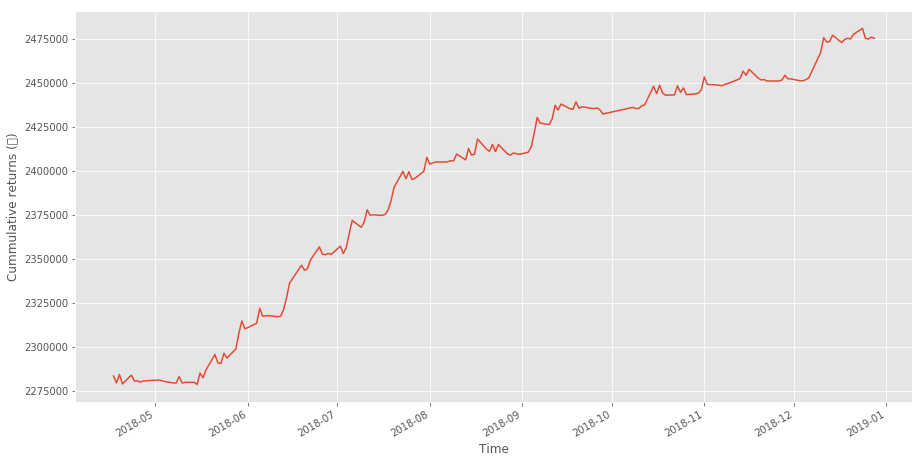

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 8.45%
net_performance pct chg: 8.40%
total_com_costs: ￥1180.00
total_com_costs impact percentage:0.05%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting IC000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\IC000_d.csv
start_date:  2015/04/16
         date    open    high     low   close  volume  open_interests  margin  \
0  2015/04/16  7664.0  7786.6  7482.2  7698.4  123400            7940    0.08   
1  2015/04/17  7710.0  7895.2  7623.6  7739.0  122985           11159    0.08   
2  2015/04/20  7744.4  7835.6  7561.4  7597.0  105224         

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 77.00 %
F1 Score: 0.7658
Area Under ROC Curve Score: 0.7700
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 49.43 %
F1 Score: 0.5291
Area Under ROC Curve Score: 0.5072
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18   -1
2018-04-19    1
2018-04-20   -1
2018-04-23    1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  5933.2        NaN            NaN          0        1     NaN   
2018-04-17  5824.6 

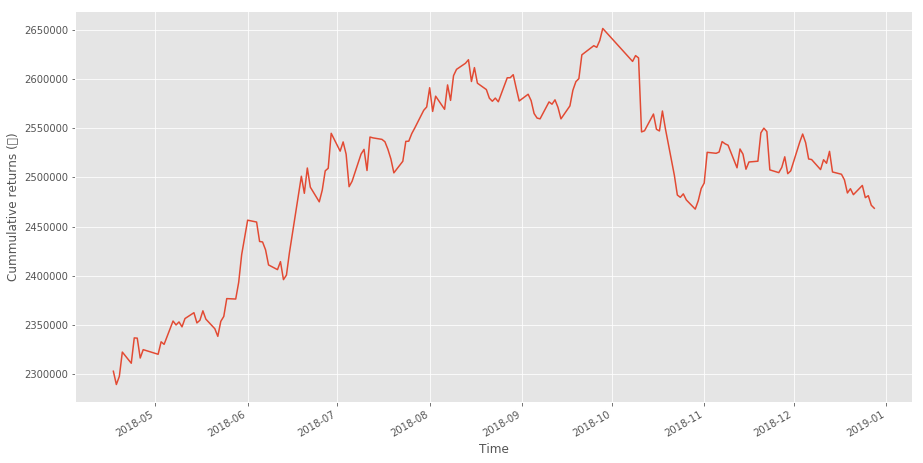

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 7.31%
net_performance pct chg: 7.21%
total_com_costs: ￥2421.86
total_com_costs impact percentage:0.11%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting j9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\j9000_d.csv
start_date:  2011/04/15
         date    open    high     low   close  volume  open_interests  margin  \
0  2011/04/15  2275.0  2285.0  2228.0  2250.0   58080            6694    0.05   
1  2011/04/18  2239.0  2389.0  2237.0  2382.0  133636           19940    0.05   
2  2011/04/19  2371.0  2385.0  2321.0  2337.0  205268         

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 77.13 %
F1 Score: 0.7621
Area Under ROC Curve Score: 0.7713
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 50.00 %
F1 Score: 0.5165
Area Under ROC Curve Score: 0.5017
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18    1
2018-04-19    1
2018-04-20    1
2018-04-23   -1
2018-04-24   -1
2018-04-25   -1
2018-04-26   -1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  1750.5        NaN            NaN          0        1     NaN   
2018-04-17  1788.0 

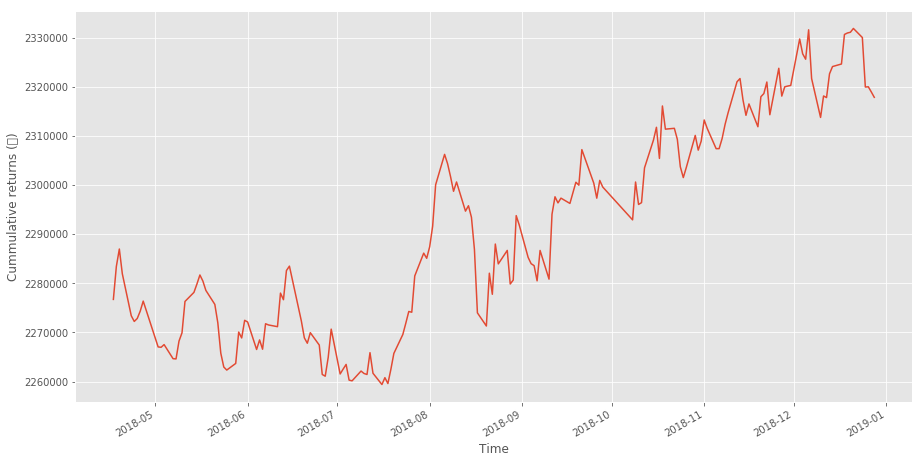

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 1.86%
net_performance pct chg: 1.81%
total_com_costs: ￥1047.34
total_com_costs impact percentage:0.05%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting l9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\l9000_d.csv
start_date:  2007/07/31
         date   open   high    low  close  volume  open_interests  margin  \
0  2007/07/31  12798  12900  12473  12577   36330            3708    0.05   
1  2007/08/01  12623  12623  12402  12454    7062            3266    0.05   
2  2007/08/02  12426  12461  12286  12442    6610            3644    0.05 

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 79.37 %
F1 Score: 0.8030
Area Under ROC Curve Score: 0.7937
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 53.41 %
F1 Score: 0.5729
Area Under ROC Curve Score: 0.5323
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17    1
2018-04-18    1
2018-04-19    1
2018-04-20    1
2018-04-23    1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:              close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                      
2018-04-16   9175        NaN            NaN          1        1     NaN   
2018-04-17   9185     

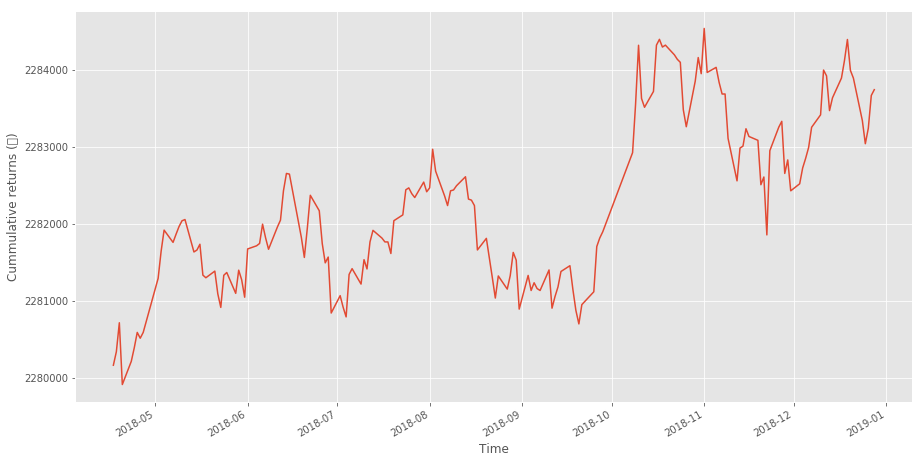

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.16%
net_performance pct chg: 0.16%
total_com_costs: ￥176.00
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting m9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\m9000_d.csv
start_date:  2000/07/17
         date  open  high   low  close  volume  open_interests  margin  unit  \
0  2000/07/17  2049  2049  1924   1954    1164             720    0.05    10   
1  2000/07/18  1981  2064  1974   1992    1302            1166    0.05    10   
2  2000/07/19  2042  2042  2014   2015     156             782    

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 76.19 %
F1 Score: 0.7656
Area Under ROC Curve Score: 0.7619
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 57.39 %
F1 Score: 0.4681
Area Under ROC Curve Score: 0.5604
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16   -1
2018-04-17    1
2018-04-18   -1
2018-04-19   -1
2018-04-20   -1
2018-04-23   -1
2018-04-24   -1
2018-04-25   -1
2018-04-26   -1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:              close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                      
2018-04-16   3204        NaN            NaN          1       -1     NaN   
2018-04-17   3267     

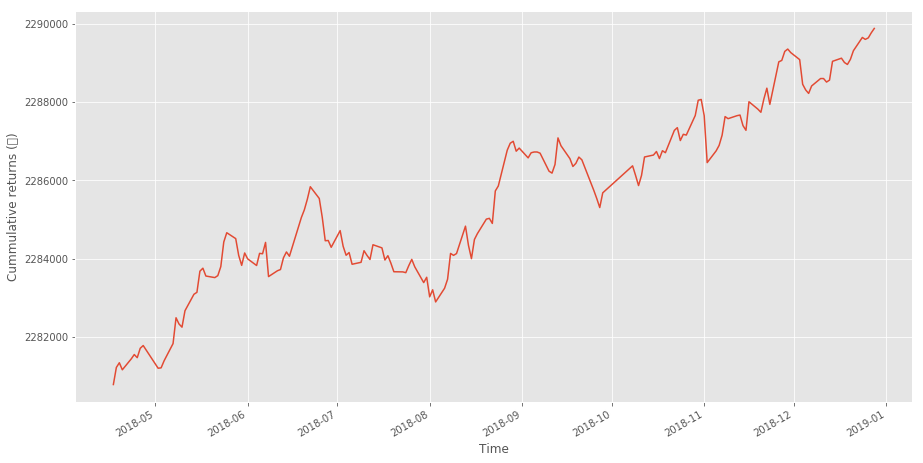

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.40%
net_performance pct chg: 0.40%
total_com_costs: ￥124.75
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting OI000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\OI000_d.csv
start_date:  2012/09/20
         date   open   high    low  close  volume  open_interests  margin  \
0  2012/09/20  10430  10430  10430  10430       2               2    0.05   
1  2012/09/26  10018  10794  10012  10794       8               2    0.05   
2  2012/10/10  10130  10130  10130  10130       2               4    0.05  

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 79.96 %
F1 Score: 0.8105
Area Under ROC Curve Score: 0.7996
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 50.57 %
F1 Score: 0.4727
Area Under ROC Curve Score: 0.5050
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18   -1
2018-04-19   -1
2018-04-20    1
2018-04-23   -1
2018-04-24   -1
2018-04-25   -1
2018-04-26    1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:              close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                      
2018-04-16   6480        NaN            NaN          0        1     NaN   
2018-04-17   6486     

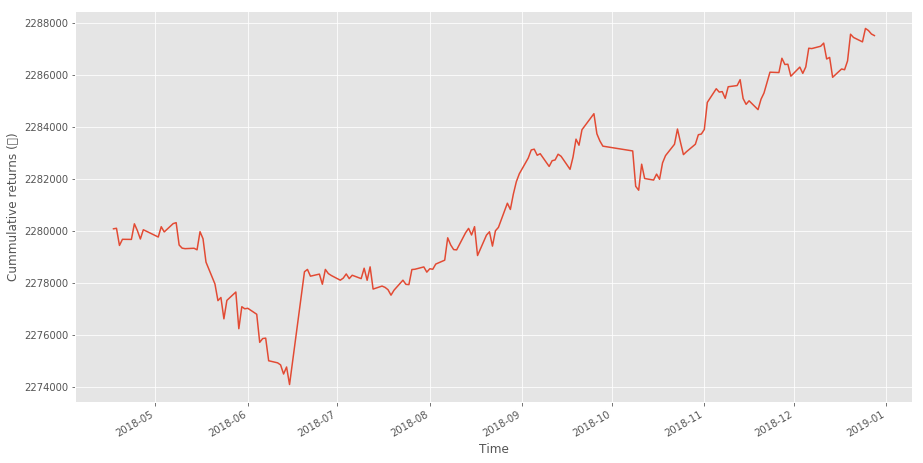

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.34%
net_performance pct chg: 0.33%
total_com_costs: ￥224.00
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting T9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\T9000_d.csv
start_date:  2015/03/20
         date    open    high     low  close  volume  open_interests  margin  \
0  2015/03/20  96.900  97.965  96.545  97.11    3417             862    0.02   
1  2015/03/23  97.115  97.115  96.875  97.03    1387            1727    0.02   
2  2015/03/24  97.140  97.220  96.890  96.93    1383            21

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Validation datasets performance: 
Accuracy Score: 43.18 %
F1 Score: 0.3671
Area Under ROC Curve Score: 0.4470
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17    1
2018-04-18   -1
2018-04-19   -1
2018-04-20   -1
2018-04-23   -1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  94.355        NaN            NaN          1        1     NaN   
2018-04-17  94.340        0.0            0.0          0        1     0.0   
2018-04-18  95.340        6.0            6.0          0       -1    -2.0   
2018-04-19  95.115        0.0 

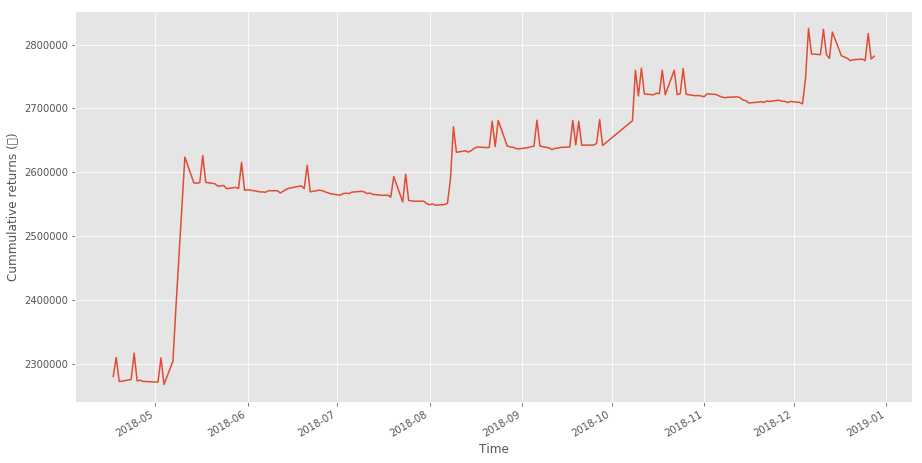

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 22.01%
net_performance pct chg: 22.00%
total_com_costs: ￥192.00
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting au000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\au000_d.csv
start_date:  2008/01/09
         date   open   high    low  close  volume  open_interests  margin  \
0  2008/01/09  231.0  231.0  222.0  224.0  121468           21810    0.07   
1  2008/01/10  223.0  223.0  214.0  216.0   95064           29350    0.07   
2  2008/01/11  218.0  219.0  216.0  218.0   90882           32414    0.07

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 72.97 %
F1 Score: 0.7223
Area Under ROC Curve Score: 0.7297
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 49.43 %
F1 Score: 0.4914
Area Under ROC Curve Score: 0.4947
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16   -1
2018-04-17    1
2018-04-18    1
2018-04-19   -1
2018-04-20   -1
2018-04-23   -1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  274.95        NaN            NaN          1       -1     NaN   
2018-04-17  275.35 

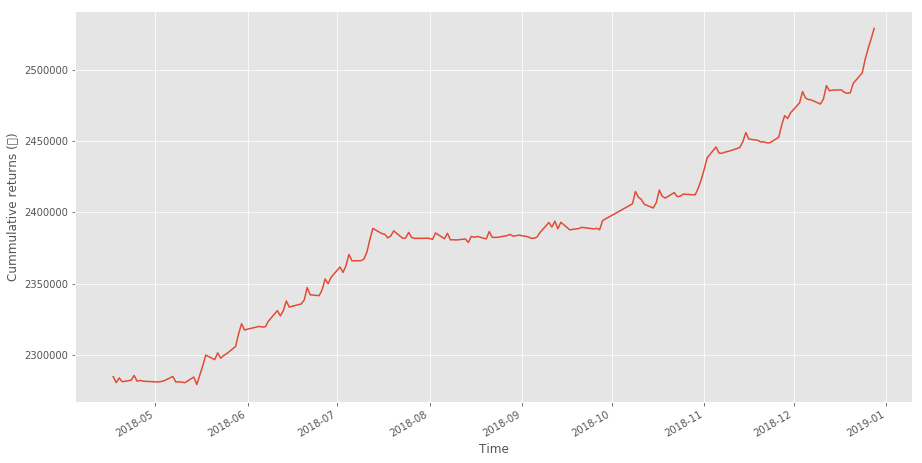

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 10.77%
net_performance pct chg: 10.71%
total_com_costs: ￥1280.00
total_com_costs impact percentage:0.06%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting IC000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\IC000_d.csv
start_date:  2015/04/16
         date    open    high     low   close  volume  open_interests  margin  \
0  2015/04/16  7664.0  7786.6  7482.2  7698.4  123400            7940    0.08   
1  2015/04/17  7710.0  7895.2  7623.6  7739.0  122985           11159    0.08   
2  2015/04/20  7744.4  7835.6  7561.4  7597.0  105224       

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 75.20 %
F1 Score: 0.7293
Area Under ROC Curve Score: 0.7520
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 51.70 %
F1 Score: 0.5972
Area Under ROC Curve Score: 0.5431
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17    1
2018-04-18    1
2018-04-19    1
2018-04-20    1
2018-04-23    1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  5933.2        NaN            NaN          1        1     NaN   
2018-04-17  5824.6 

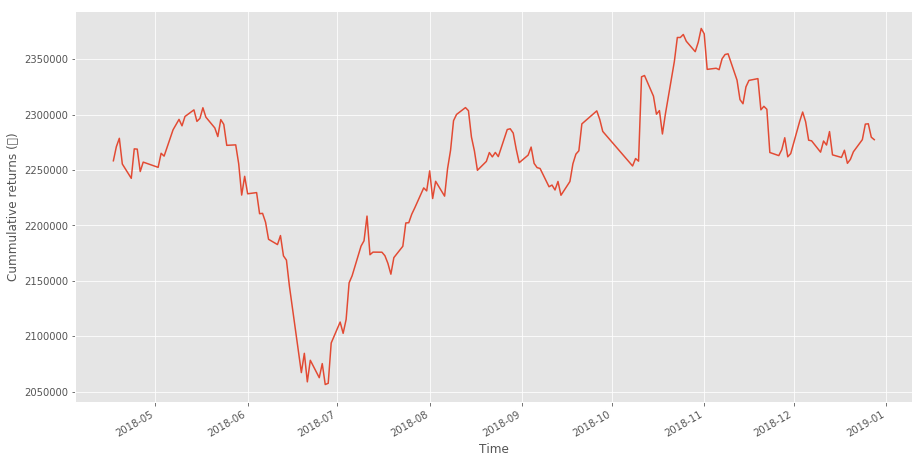

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.91%
net_performance pct chg: 0.84%
total_com_costs: ￥1401.45
total_com_costs impact percentage:0.06%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting j9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\j9000_d.csv
start_date:  2011/04/15
         date    open    high     low   close  volume  open_interests  margin  \
0  2011/04/15  2275.0  2285.0  2228.0  2250.0   58080            6694    0.05   
1  2011/04/18  2239.0  2389.0  2237.0  2382.0  133636           19940    0.05   
2  2011/04/19  2371.0  2385.0  2321.0  2337.0  205268         

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 73.45 %
F1 Score: 0.7175
Area Under ROC Curve Score: 0.7345
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 47.73 %
F1 Score: 0.4524
Area Under ROC Curve Score: 0.4763
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17    1
2018-04-18    1
2018-04-19   -1
2018-04-20   -1
2018-04-23    1
2018-04-24   -1
2018-04-25   -1
2018-04-26   -1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  1750.5        NaN            NaN          1        1     NaN   
2018-04-17  1788.0 

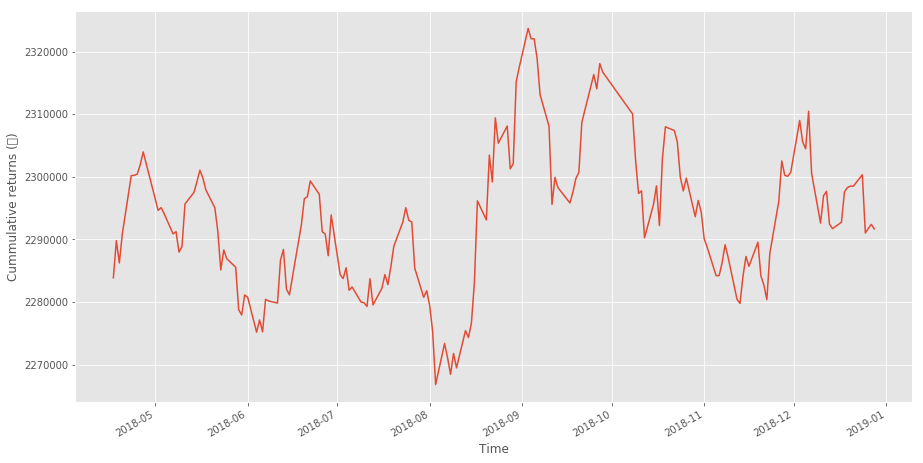

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.40%
net_performance pct chg: 0.34%
total_com_costs: ￥1233.73
total_com_costs impact percentage:0.05%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting l9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\l9000_d.csv
start_date:  2007/07/31
         date   open   high    low  close  volume  open_interests  margin  \
0  2007/07/31  12798  12900  12473  12577   36330            3708    0.05   
1  2007/08/01  12623  12623  12402  12454    7062            3266    0.05   
2  2007/08/02  12426  12461  12286  12442    6610            3644    0.05 

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 79.56 %
F1 Score: 0.8023
Area Under ROC Curve Score: 0.7956
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 47.16 %
F1 Score: 0.5131
Area Under ROC Curve Score: 0.4699
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18   -1
2018-04-19   -1
2018-04-20    1
2018-04-23    1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:              close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                      
2018-04-16   9175        NaN            NaN          0        1     NaN   
2018-04-17   9185     

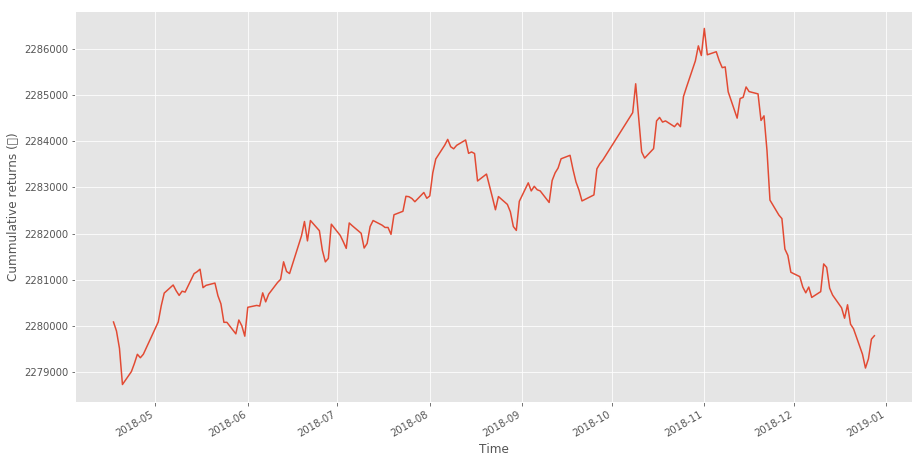

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: -0.01%
net_performance pct chg: -0.01%
total_com_costs: ￥176.00
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting m9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\m9000_d.csv
start_date:  2000/07/17
         date  open  high   low  close  volume  open_interests  margin  unit  \
0  2000/07/17  2049  2049  1924   1954    1164             720    0.05    10   
1  2000/07/18  1981  2064  1974   1992    1302            1166    0.05    10   
2  2000/07/19  2042  2042  2014   2015     156             782  

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 76.19 %
F1 Score: 0.7561
Area Under ROC Curve Score: 0.7619
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 50.57 %
F1 Score: 0.4314
Area Under ROC Curve Score: 0.4979
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18   -1
2018-04-19   -1
2018-04-20   -1
2018-04-23   -1
2018-04-24   -1
2018-04-25   -1
2018-04-26   -1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:              close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                      
2018-04-16   3204        NaN            NaN          0        1     NaN   
2018-04-17   3267     

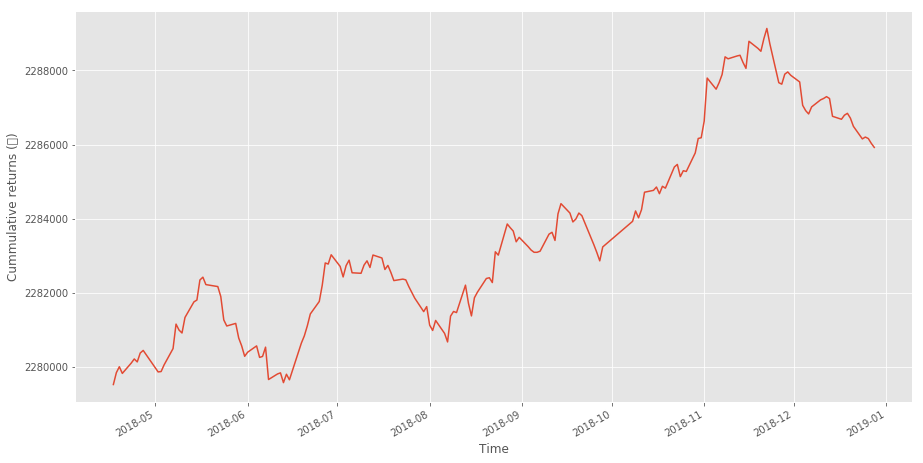

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.29%
net_performance pct chg: 0.28%
total_com_costs: ￥146.83
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting OI000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\OI000_d.csv
start_date:  2012/09/20
         date   open   high    low  close  volume  open_interests  margin  \
0  2012/09/20  10430  10430  10430  10430       2               2    0.05   
1  2012/09/26  10018  10794  10012  10794       8               2    0.05   
2  2012/10/10  10130  10130  10130  10130       2               4    0.05  

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16    1
2018-04-17   -1
2018-04-18   -1
2018-04-19    1
2018-04-20   -1
2018-04-23    1
2018-04-24    1
2018-04-25    1
2018-04-26    1
2018-04-27    1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:              close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                      
2018-04-16   6480        NaN            NaN          0        1     NaN   
2018-04-17   6486        4.0            4.0          0       -1    -2.0   
2018-04-18   6480        0.0            4.0          1       -1     0.0   
2018-04-19   6546        4.0            8.0          0        1     2.0   
2018-04-20   6566        4.0           12.0          1       -1    -2.0   

            slpg_costs  slpged_price  slpged_pr

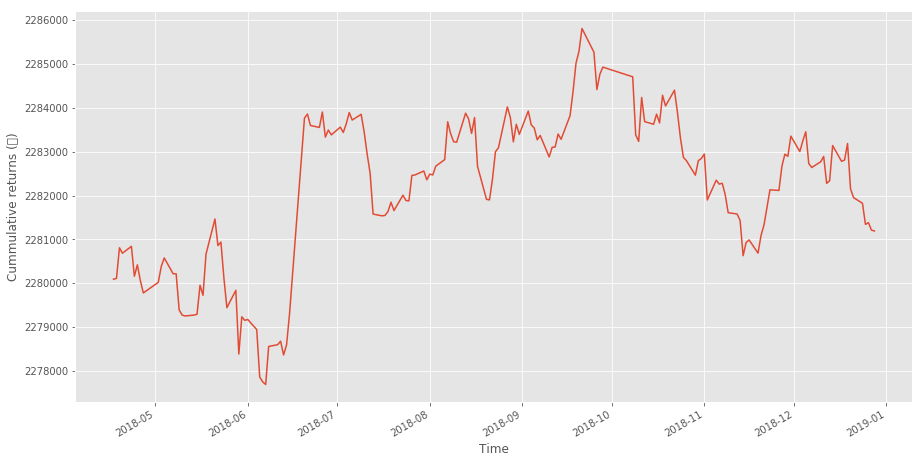

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 0.05%
net_performance pct chg: 0.05%
total_com_costs: ￥136.00
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
=====================================Start backtesting T9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/12_28_commodities_daily/7_daily_commodities\T9000_d.csv
start_date:  2015/03/20
         date    open    high     low  close  volume  open_interests  margin  \
0  2015/03/20  96.900  97.965  96.545  97.11    3417             862    0.02   
1  2015/03/23  97.115  97.115  96.875  97.03    1387            1727    0.02   
2  2015/03/24  97.140  97.220  96.890  96.93    1383            21

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 75.10 %
F1 Score: 0.7292
Area Under ROC Curve Score: 0.7510
----------------------------------------------------
Validation datasets performance: 
Accuracy Score: 51.14 %
F1 Score: 0.4625
Area Under ROC Curve Score: 0.5262
----------------------------------------------------
==================Peeking price len================= 176
===================Peeking mask ===================== date
2018-04-16   -1
2018-04-17   -1
2018-04-18   -1
2018-04-19   -1
2018-04-20   -1
2018-04-23   -1
2018-04-24   -1
2018-04-25   -1
2018-04-26   -1
2018-04-27   -1
dtype: int32
======================Peeking net_portfolio_equity len====================== 176
================Peeking model_rtrn_df=================:               close  com_costs  cum_com_costs  y_pred_sr  signals  if_chg  \
date                                                                       
2018-04-16  94.355        NaN            NaN          0       -1     NaN   
2018-04-17  94.340 

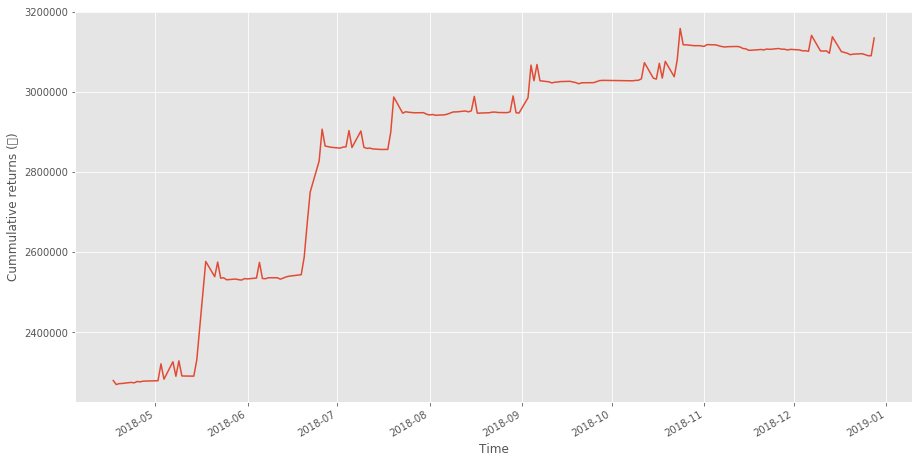

close len: 176
mask len:  176
data_returns len:  176
model_returns len:  176
model_cum len:  176
net_portfolio_equity len:  176
commissions_costs len 176
performance pct chg: 37.46%
net_performance pct chg: 37.45%
total_com_costs: ￥186.00
total_com_costs impact percentage:0.01%, (/start_capital)
=============================================All Finished.==================================================
   commodity  backtest   n  test_size  rblnc_rs  tts_rs  rf_rs  n_estimators  \
0      au000         1   5   0.166667         5       5      5            10   
1      IC000         2   5   0.166667         5       5      5            10   
2      j9000         3   5   0.166667         5       5      5            10   
3      l9000         4   5   0.166667         5       5      5            10   
4      m9000         5   5   0.166667         5       5      5            10   
5      OI000         6   5   0.166667         5       5      5            10   
6      T9000         7   5   0.166

In [558]:
backtest_records, backtest_curves, df_bt, model_rtrn_df, df, costs, total_paras_sets = random_forest_run_backtests('close', rf_paras, start_capital, trade_freq, location, folder, rf_backtest_records, '2016-04-15', '2018-04-15', '2019-01-15')

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel_launcher.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


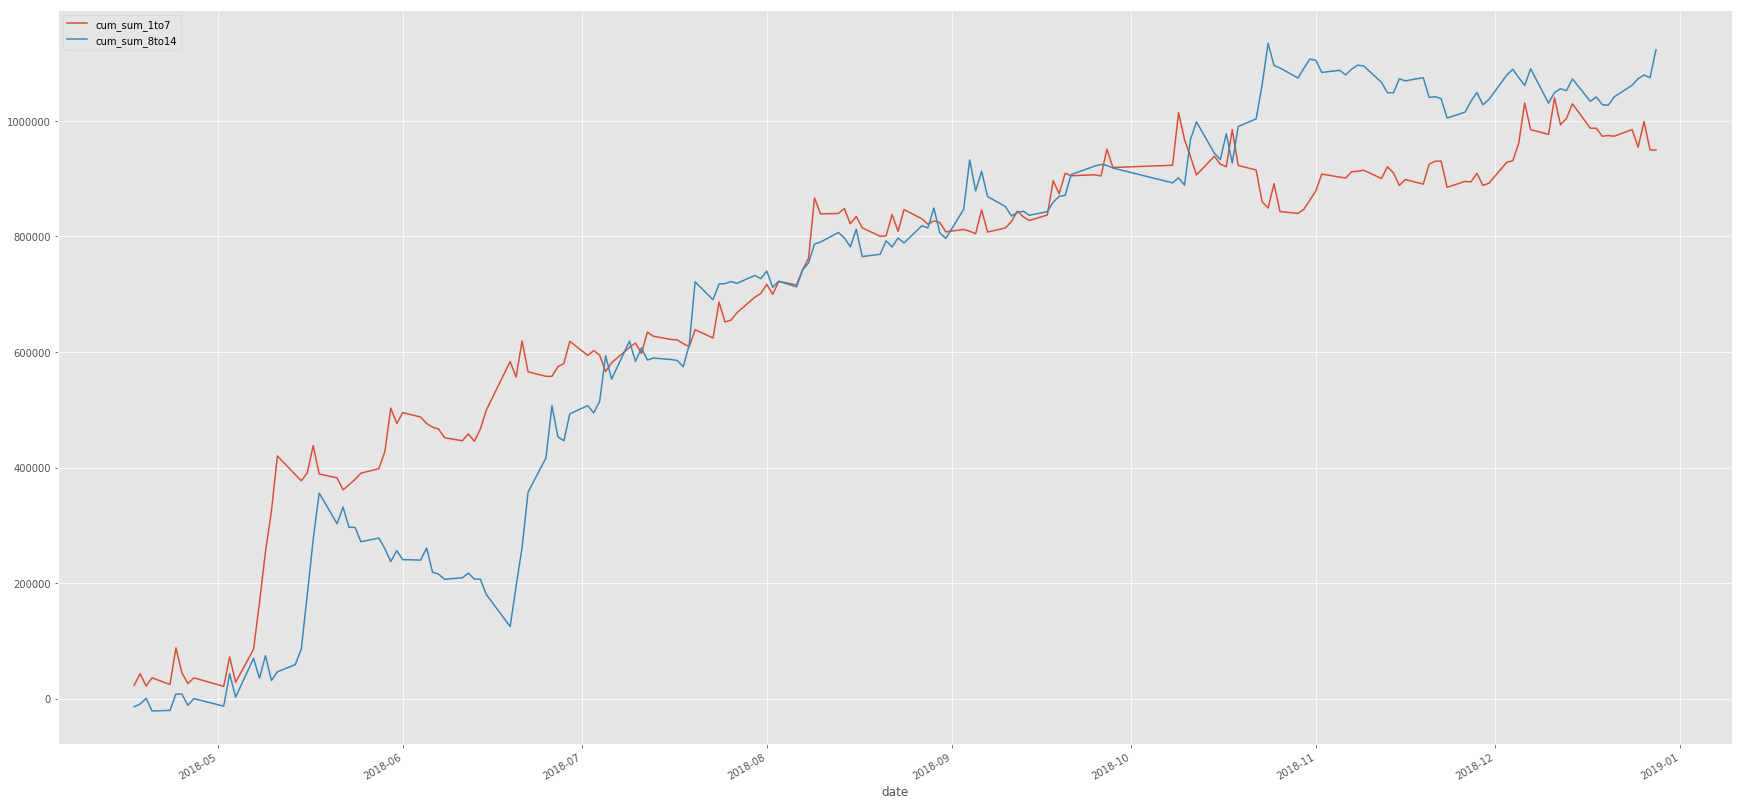

In [577]:
backtest_sets_df, performances_df = gen_bt_sets(total_paras_sets, backtest_curves, location, trade_freq, start_capital)

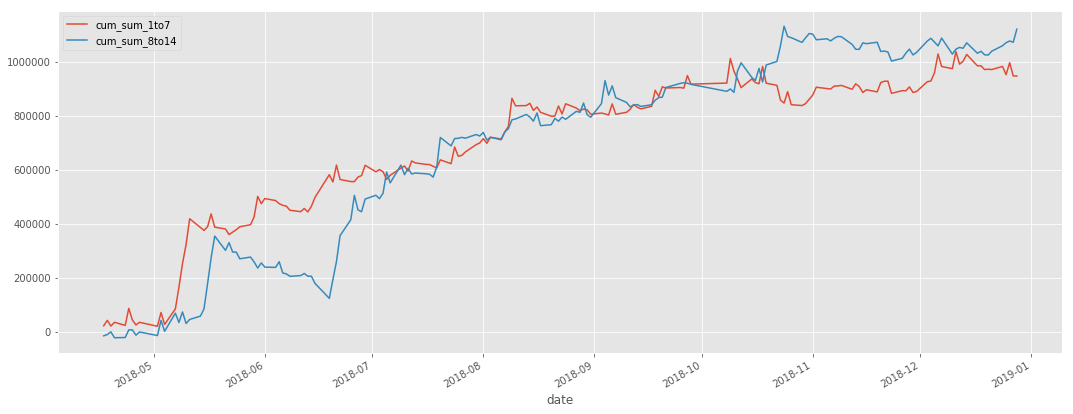

In [580]:
backtest_sets_df.plot(figsize=(18, 7))

In [584]:
model_rtrn_df

,close,com_costs,cum_com_costs,y_pred_sr,signals,if_chg,slpg_costs,slpged_price,slpged_price_diff,values_per_con,target_con,pos_values,pos_values_returns,model_cum,portfolio_equity,net_portfolio_equity,ticker,date,bt
date,,,,,,,,,,,,,,,,,,,
2018-04-16,94.355,NaN,NaN,0,-1,NaN,NaN,94.355,NaN,943550.0,1,943550.0,NaN,NaN,NaN,NaN,T9000,2018-04-16,14
2018-04-17,94.340,0.0,0.0,0,-1,0.0,0.0,94.340,-0.015,943400.0,1,943400.0,150.0,150.0,2280270.0,2280270.0,T9000,2018-04-17,14
2018-04-18,95.340,0.0,0.0,0,-1,0.0,0.0,95.340,1.000,953400.0,1,953400.0,-10000.0,-9850.0,2270270.0,2270270.0,T9000,2018-04-18,14
2018-04-19,95.115,0.0,0.0,0,-1,0.0,0.0,95.115,-0.225,951150.0,1,951150.0,2250.0,-7600.0,2272520.0,2272520.0,T9000,2018-04-19,14
2018-04-20,95.075,0.0,0.0,0,-1,0.0,0.0,95.075,-0.040,950750.0,1,950750.0,400.0,-7200.0,2272920.0,2272920.0,T9000,2018-04-20,14
2018-04-23,94.805,0.0,0.0,0,-1,0.0,0.0,94.805,-0.270,948050.0,1,948050.0,2700.0,-4500.0,2275620.0,2275620.0,T9000,2018-04-23,14
2018-04-24,94.930,0.0,0.0,0,-1,0.0,0.0,94.930,0.125,949300.0,1,949300.0,-1250.0,-5750.0,2274370.0,2274370.0,T9000,2018-04-24,14
2018-04-25,94.575,0.0,0.0,0,-1,0.0,0.0,94.575,-0.355,945750.0,1,945750.0,3550.0,-2200.0,2277920.0,2277920.0,T9000,2018-04-25,14
2018-04-26,94.685,0.0,0.0,0,-1,0.0,0.0,94.685,0.110,946850.0,1,946850.0,-1100.0,-3300.0,2276820.0,2276820.0,T9000,2018-04-26,14


In [543]:
df_bt.sort_values("sharpe", ascending=False)

,commodity,backtest,n,test_size,rblnc_rs,tts_rs,rf_rs,n_estimators,max_depth,min_samples_split,sharpe,trades,accuracy
4,m9000,5,5,0.166667,5,5,5,10,10,2,4.521790,34,0.573864
207,m9000,208,10,0.166667,5,5,5,50,50,10,4.286309,33,0.517045
249,m9000,250,10,0.166667,5,5,5,100,50,10,4.286309,33,0.517045
165,m9000,166,10,0.166667,5,5,5,10,50,10,4.286309,33,0.517045
181,T9000,182,10,0.166667,5,5,5,50,10,10,4.225159,54,0.511364
223,T9000,224,10,0.166667,5,5,5,100,10,10,4.225159,54,0.511364
189,au000,190,10,0.166667,5,5,5,50,20,10,4.109020,44,0.551136
231,au000,232,10,0.166667,5,5,5,100,20,10,4.109020,44,0.551136
170,j9000,171,10,0.166667,5,5,5,50,10,2,3.991157,49,0.534091
212,j9000,213,10,0.166667,5,5,5,100,10,2,3.991157,49,0.534091


In [555]:
backtest_curves

,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8,bt9,bt10,...,bt243,bt244,bt245,bt246,bt247,bt248,bt249,bt250,bt251,bt252
date,,,,,,,,,,,,,,,,,,,,,
2018-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-17,3600.0,22520.0,-3350.0,50.0,670.0,-20.0,-150.0,-400.0,22520.0,3750.0,...,630.0,-20.0,39850.0,4400.0,22520.0,4150.0,50.0,630.0,-20.0,39850.0
2018-04-18,-300.0,9000.0,3400.0,225.0,1110.0,0.0,29850.0,-300.0,9000.0,9700.0,...,1030.0,0.0,109850.0,12500.0,36840.0,9700.0,225.0,1030.0,0.0,9850.0
2018-04-19,4450.0,17360.0,6950.0,600.0,1230.0,-660.0,-7900.0,4450.0,17360.0,13650.0,...,1150.0,700.0,72100.0,7750.0,43600.0,13650.0,-130.0,1150.0,700.0,52100.0
2018-04-20,-900.0,42160.0,1900.0,-200.0,1050.0,-420.0,-7500.0,-900.0,42160.0,8600.0,...,970.0,860.0,72500.0,9100.0,20400.0,8600.0,-890.0,970.0,860.0,12500.0
2018-04-23,4150.0,30840.0,-6650.0,100.0,1330.0,-420.0,-4800.0,4150.0,54280.0,50.0,...,1250.0,940.0,75200.0,10150.0,7480.0,17550.0,-610.0,1250.0,940.0,15200.0
2018-04-24,750.0,56640.0,-7800.0,275.0,1440.0,180.0,36450.0,750.0,81680.0,-1100.0,...,1180.0,300.0,73950.0,10750.0,34080.0,17200.0,-765.0,1360.0,1620.0,13950.0
2018-04-25,800.0,56400.0,-7200.0,475.0,1360.0,-80.0,-7100.0,800.0,80640.0,-1300.0,...,1180.0,560.0,77500.0,10800.0,33840.0,17400.0,-525.0,1280.0,1320.0,17500.0
2018-04-26,200.0,36160.0,-5700.0,400.0,1600.0,-400.0,-6000.0,200.0,60400.0,1000.0,...,1380.0,200.0,76400.0,10200.0,13600.0,19700.0,-410.0,1520.0,1680.0,58600.0


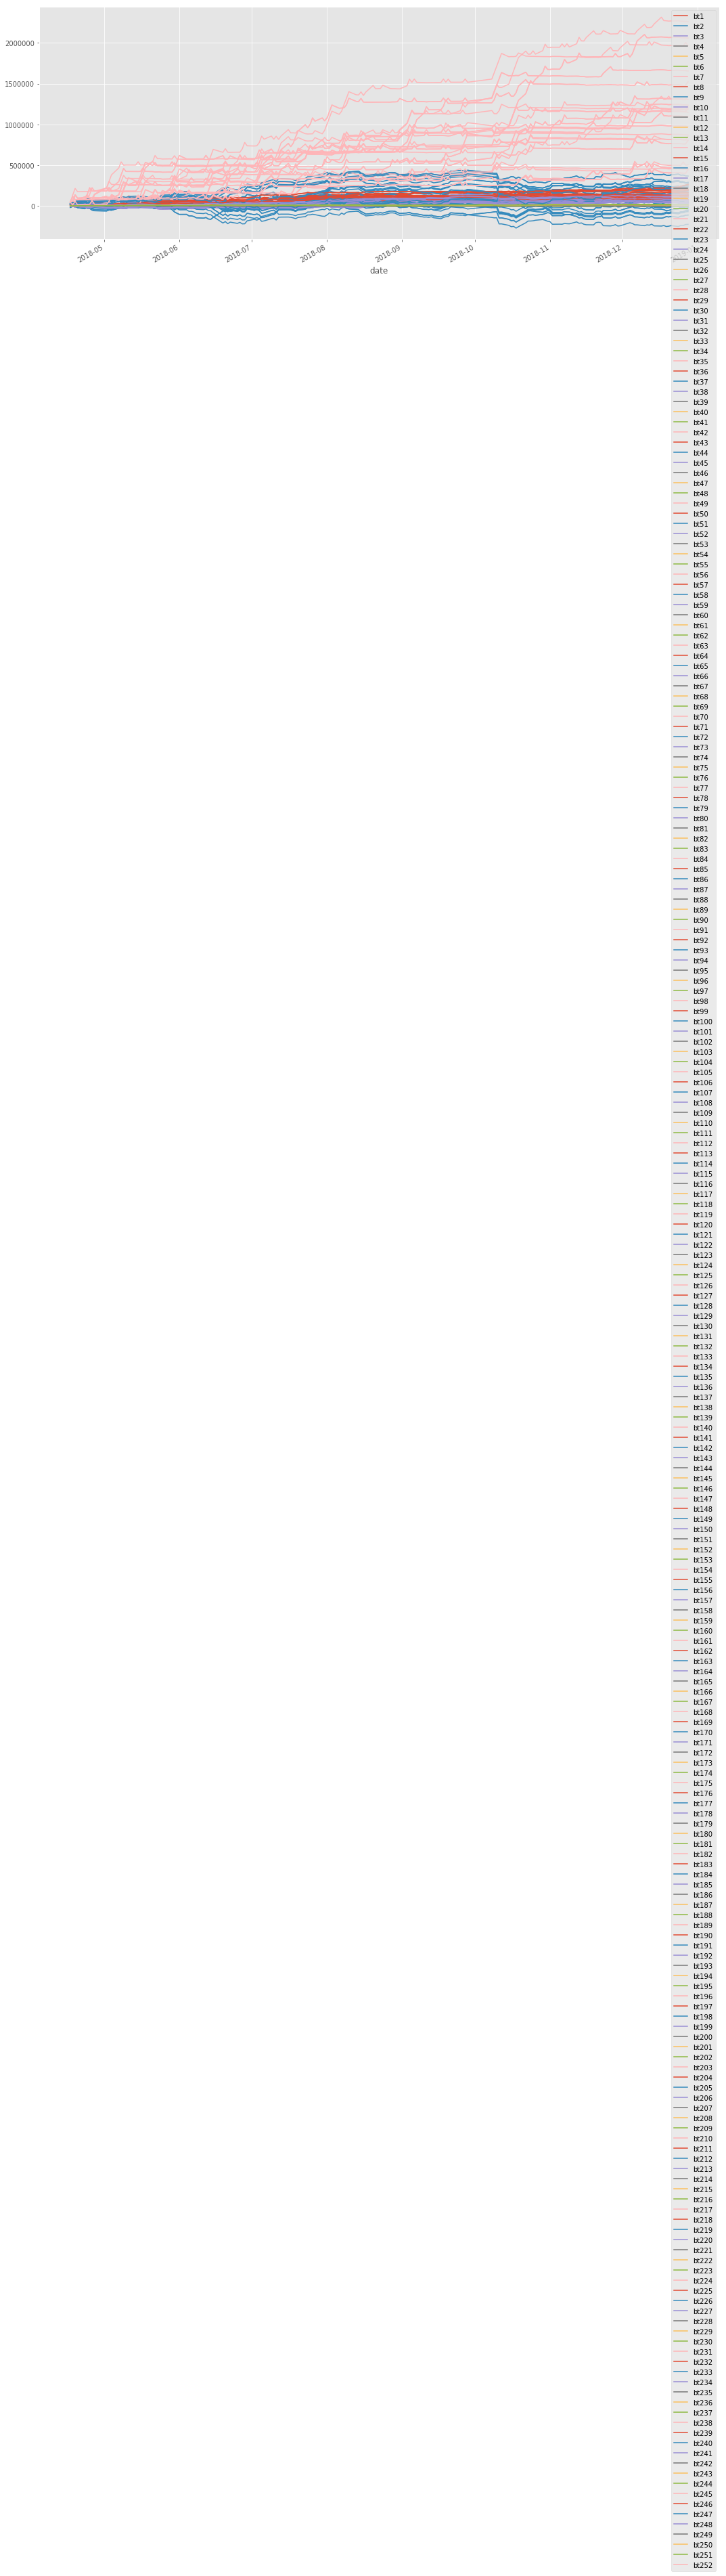

In [532]:
backtest_curves.plot(figsize=(18, 7))

## 检查为何bt7和bt14会如此平稳

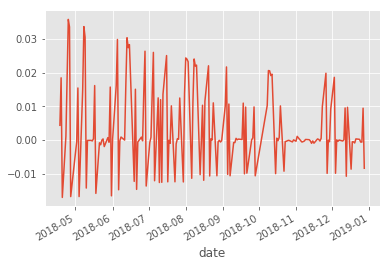

In [549]:
bt14 = df[(df['ticker']=='T9000')&(df['bt']==14)]
bt14_returns = bt14['portfolio_equity'].pct_change()
bt14_returns.dropna().plot()

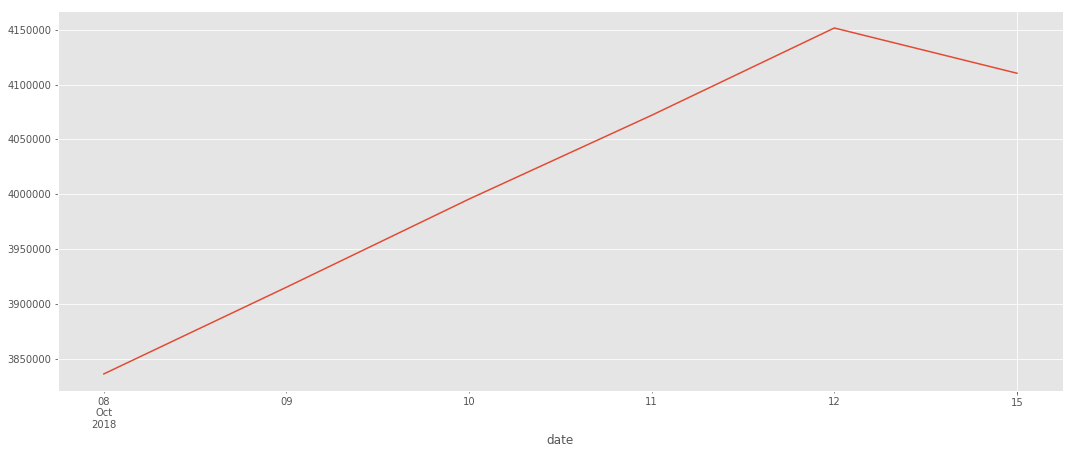

In [553]:
bt14['portfolio_equity']['2018-10-8':'2018-10-15'].plot(figsize = (18, 7))

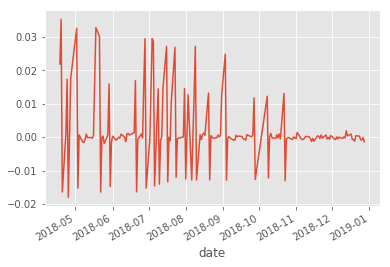

In [519]:
bt7 = df[(df['ticker']=='T9000')&(df['bt']==7)]
bt7_returns = bt7['portfolio_equity'].pct_change()
bt7_returns.dropna().plot()

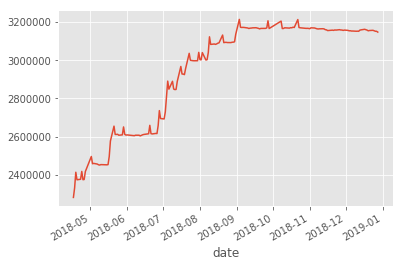

In [547]:
bt7['portfolio_equity'].plot()

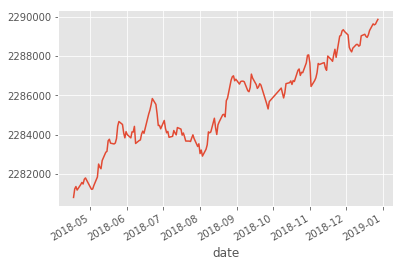

In [546]:
df[df['bt']==5]['net_portfolio_equity'].plot()

In [531]:
df.to_csv(folder+"results_samples/"+"1_30_2019_all_df_backtested_results_sample_2.csv")

# 滚动回测AIO运行测试

In [10]:
ttv_split_dict = {
    'ttv2':{
        'tt_start':'2016-04-15',
        'tt_end'   :'2018-04-15',
        'val_end' :'2019-01-15'            
        },
    
    'ttv1':{
            'tt_start':'2015-04-15',
            'tt_end'   :'2017-04-15',
            'val_end' :'2018-04-15'
            }}

# ttv1_1 = ttv_split_dict['ttv1']['tt_start']
# ttv1_2 = ttv_split_dict['ttv1']['tt_end']
# ttv1_3 = ttv_split_dict['ttv1']['val_end']

# ttv2_1 = ttv_split_dict['ttv2']['tt_start']
# ttv2_2 = ttv_split_dict['ttv2']['tt_end']
# ttv2_3 = ttv_split_dict['ttv2']['val_end']

In [11]:
for ttv in ttv_split_dict.keys():
    print ("Running AIO backtests for periods: ", ttv_split_dict[ttv])

Running AIO backtests for periods:  {'tt_end': '2017-04-15', 'tt_start': '2015-04-15', 'val_end': '2018-04-15'}
Running AIO backtests for periods:  {'tt_end': '2018-04-15', 'tt_start': '2016-04-15', 'val_end': '2019-01-15'}


Running AIO backtests for periods:  {'tt_end': '2017-04-15', 'tt_start': '2015-04-15', 'val_end': '2018-04-15'}
总共参数组合有2组
总共商品数量有7个
总共回测数量有14个
=====================================Start backtesting au000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\au000_4h.csv
file asset start date:  2008-1-9 8:00
majority:1, length: 970; minority:0, length: 957
-----------------------------------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



X length:  1940
X_val length:  965
X_train length:  1616
X_test length:  324
-----------------------------------------------
y length:  1940
y_val length:  965
y_train length: 1616
y_test length: 324
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 70.57 %
F1 Score: 0.6993
Area Under ROC Curve Score: 0.7057
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.71 %
F1 Score: 0.5245
Area Under ROC Curve Score: 0.5187
----------------------------------------------------


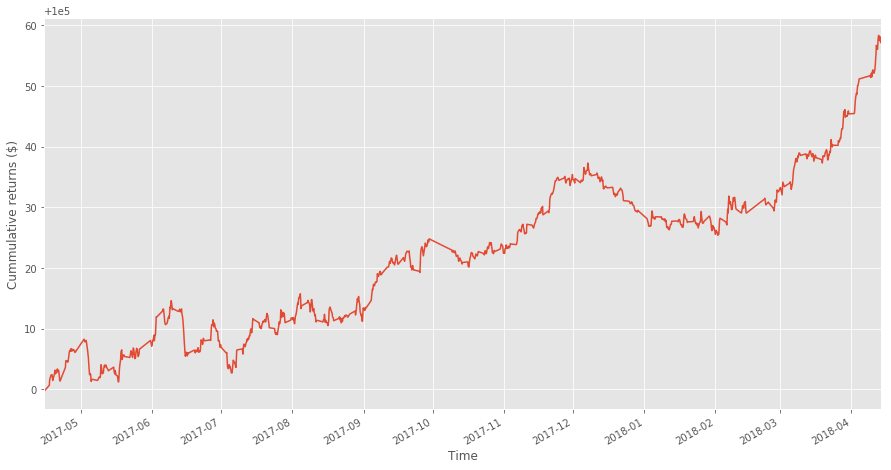

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting IC000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\IC000_4h.csv
file asset start date:  2015/04/15 08:00
majority:1, length: 502; minority:0, length: 475
-----------------------------------------------
X length:  995
X_val length:  488
X_train length:  829
X_test length:  166
-----------------------------------------------
y length:  995
y_val length:  488
y_train length: 829
y_test length: 166
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 72.36 %
F1 Score: 0.7253
Area Under ROC Curve Score: 0.7236
------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


validation datasets performance: 
Accuracy Score: 52.25 %
F1 Score: 0.5235
Area Under ROC Curve Score: 0.5226
----------------------------------------------------


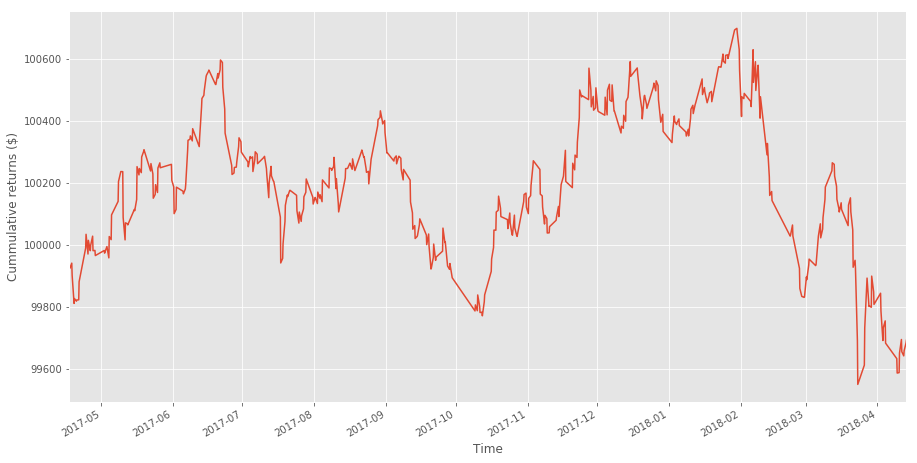

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting j9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\j9000_4h.csv
file asset start date:  2011/04/15 08:00
majority:0, length: 745; minority:1, length: 722
-----------------------------------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



X length:  1490
X_val length:  726
X_train length:  1241
X_test length:  249
-----------------------------------------------
y length:  1490
y_val length:  726
y_train length: 1241
y_test length: 249
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 70.60 %
F1 Score: 0.7056
Area Under ROC Curve Score: 0.7060
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.52 %
F1 Score: 0.5839
Area Under ROC Curve Score: 0.5134
----------------------------------------------------


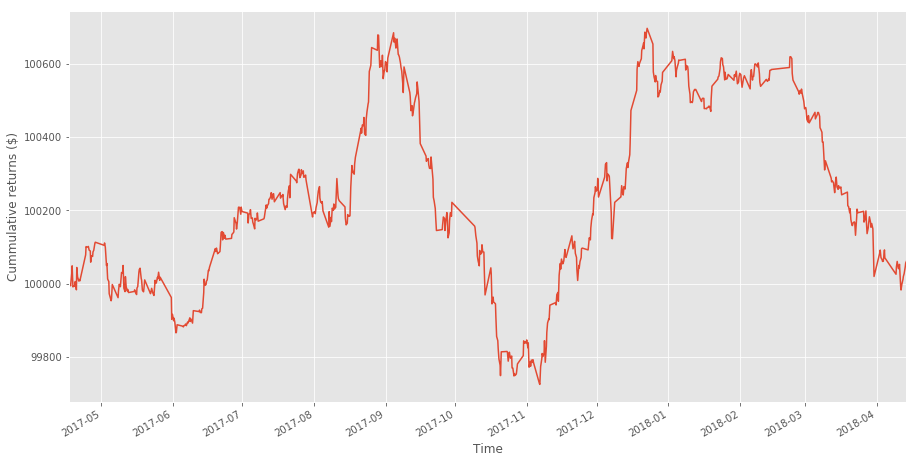

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting l9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\l9000_4h.csv
file asset start date:  2007/07/31 08:00
majority:0, length: 516; minority:1, length: 462


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1032
X_val length:  488
X_train length:  860
X_test length:  172
-----------------------------------------------
y length:  1032
y_val length:  488
y_train length: 860
y_test length: 172
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 72.19 %
F1 Score: 0.7178
Area Under ROC Curve Score: 0.7219
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.23 %
F1 Score: 0.4306
Area Under ROC Curve Score: 0.5077
----------------------------------------------------


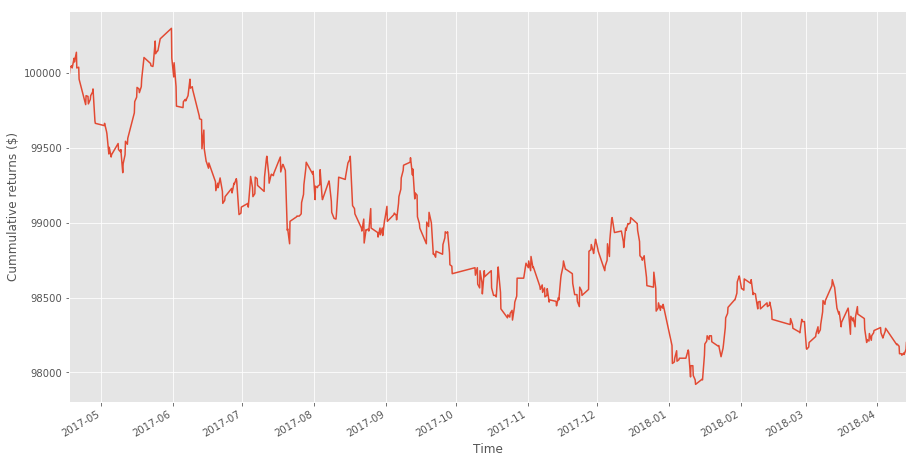

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting m9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\m9000_4h.csv
file asset start date:  2004/09/23 08:00
majority:0, length: 767; minority:1, length: 700


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1534
X_val length:  726
X_train length:  1278
X_test length:  256
-----------------------------------------------
y length:  1534
y_val length:  726
y_train length: 1278
y_test length: 256
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 69.30 %
F1 Score: 0.6858
Area Under ROC Curve Score: 0.6930
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 47.93 %
F1 Score: 0.4646
Area Under ROC Curve Score: 0.4791
----------------------------------------------------


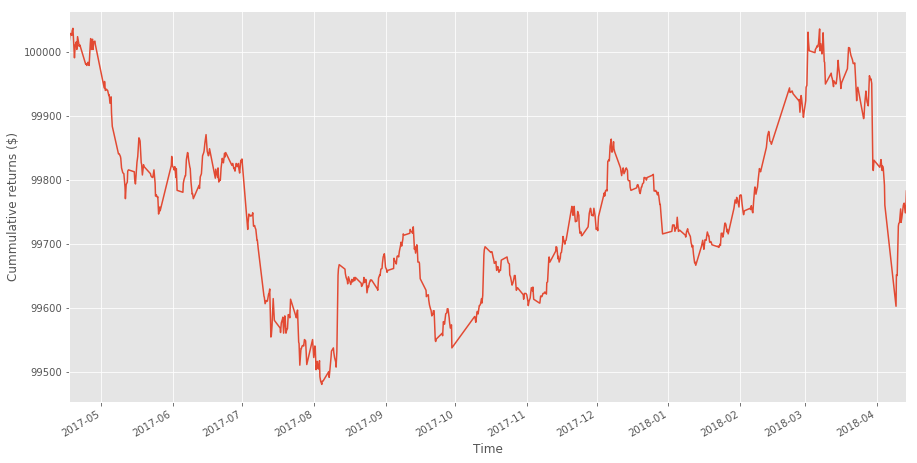

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting OI000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\OI000_4h.csv
file asset start date:  2012/09/20 08:00
majority:0, length: 720; minority:1, length: 693
-----------------------------------------------
X length:  1440
X_val length:  725
X_train length:  1200
X_test length:  240
-----------------------------------------------
y length:  1440
y_val length:  725
y_train length: 1200
y_test length: 240
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 71.88 %
F1 Score: 0.7365
Area Under ROC Curve Score: 0.7188
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.69 %
F1 Score: 0.5229
Area Under ROC Curve Score: 0.5270
----------------------------------------------------


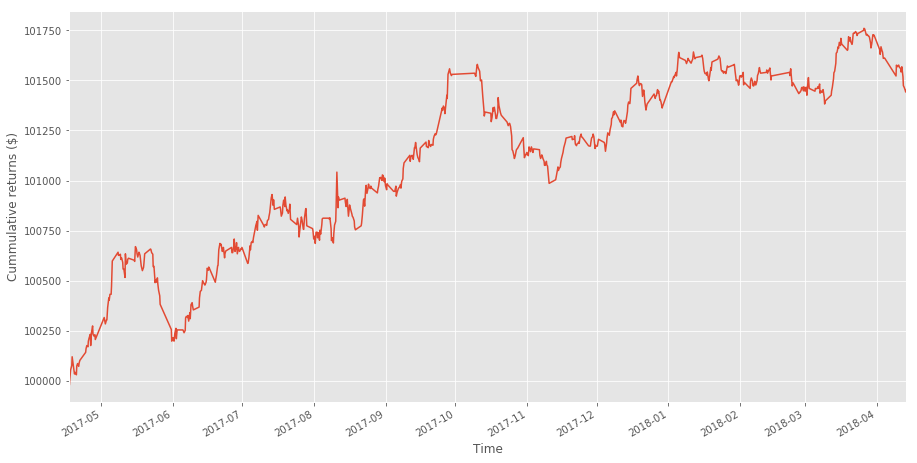

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting T9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\T9000_4h.csv
file asset start date:  2015/03/20 08:00
majority:1, length: 495; minority:0, length: 483
-----------------------------------------------
X length:  990
X_val length:  488
X_train length:  825
X_test length:  165
-----------------------------------------------
y length:  990
y_val length:  488
y_train length: 825
y_test length: 165
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 70.10 %
F1 Score: 0.6948
Area Under ROC Curve Score: 0.7010
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 48.16 %
F1 Score: 0.4606
Area Under ROC Curve Score: 0.4811
----------------------------------------------------


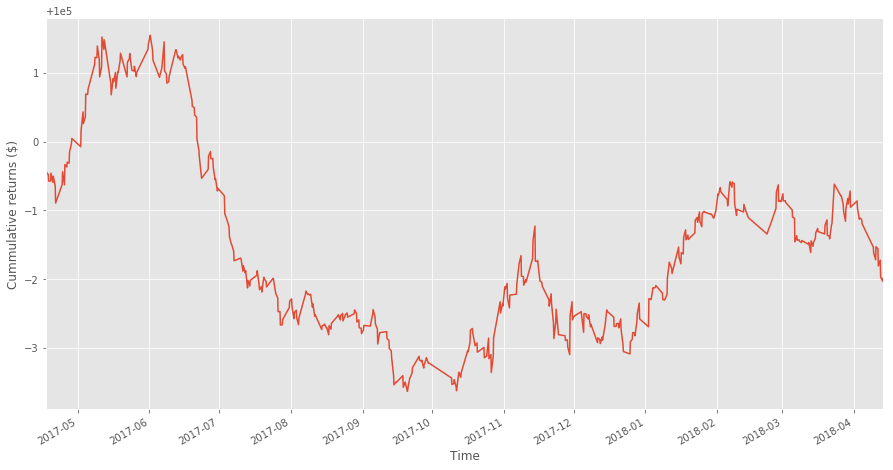

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting au000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\au000_4h.csv
file asset start date:  2008-1-9 8:00
majority:1, length: 970; minority:0, length: 957


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1940
X_val length:  965
X_train length:  1616
X_test length:  324
-----------------------------------------------
y length:  1940
y_val length:  965
y_train length: 1616
y_test length: 324
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 65.98 %
F1 Score: 0.6619
Area Under ROC Curve Score: 0.6598
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.95 %
F1 Score: 0.5478
Area Under ROC Curve Score: 0.5322
----------------------------------------------------


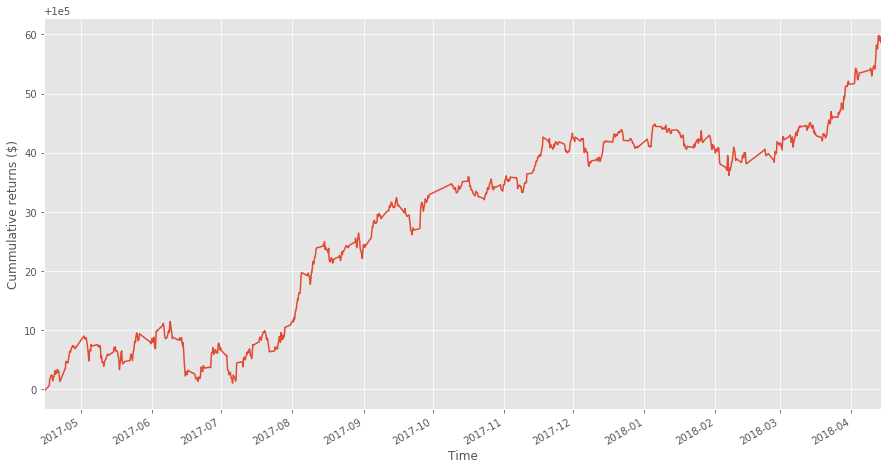

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting IC000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\IC000_4h.csv
file asset start date:  2015/04/15 08:00
majority:1, length: 502; minority:0, length: 475
-----------------------------------------------
X length:  995
X_val length:  488
X_train length:  829
X_test length:  166
-----------------------------------------------
y length:  995
y_val length:  488
y_train length: 829
y_test length: 166
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 68.04 %
F1 Score: 0.6742
Area Under ROC Curve Score: 0.6804
------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


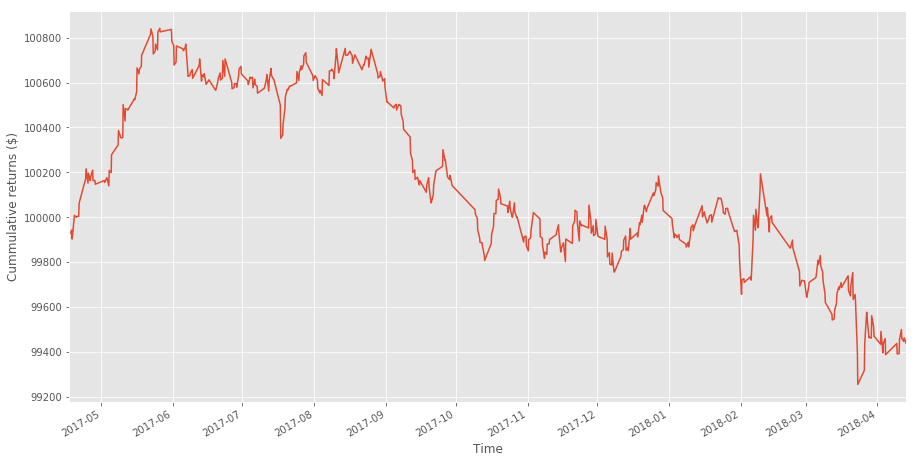

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting j9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\j9000_4h.csv
file asset start date:  2011/04/15 08:00
majority:0, length: 745; minority:1, length: 722
-----------------------------------------------
X length:  1490
X_val length:  726
X_train length:  1241
X_test length:  249
-----------------------------------------------
y length:  1490
y_val length:  726
y_train length: 1241
y_test length: 249
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 66.38 %
F1 Score: 0.6635
Area Under ROC Curve Score: 0.6638
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 51.65 %
F1 Score: 0.5904
Area Under ROC Curve Score: 0.5146
----------------------------------------------------


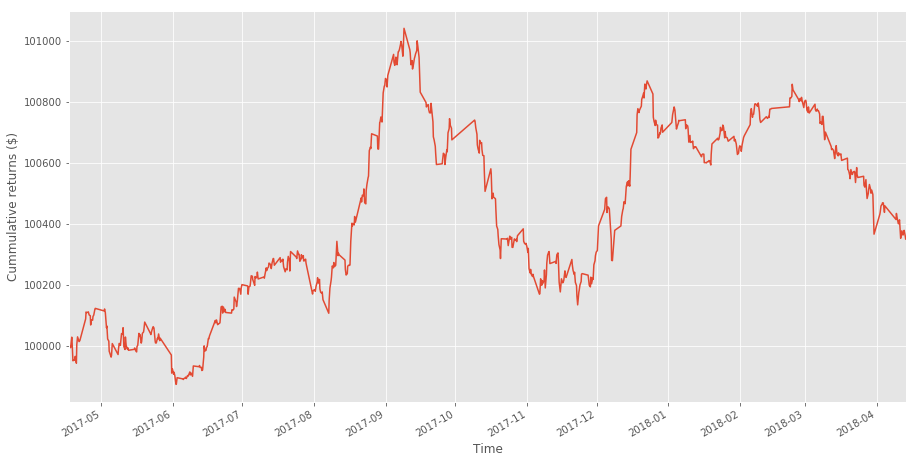

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting l9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\l9000_4h.csv
file asset start date:  2007/07/31 08:00
majority:0, length: 516; minority:1, length: 462
-----------------------------------------------
X length:  1032
X_val length:  488
X_train length:  860
X_test length:  172
-----------------------------------------------
y length:  1032
y_val length:  488
y_train length: 860
y_test length: 172
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 63.57 %
F1 Score: 0.6446
Area Under ROC Curve Score: 0.6357
----------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


validation datasets performance: 
Accuracy Score: 48.16 %
F1 Score: 0.4340
Area Under ROC Curve Score: 0.4791
----------------------------------------------------


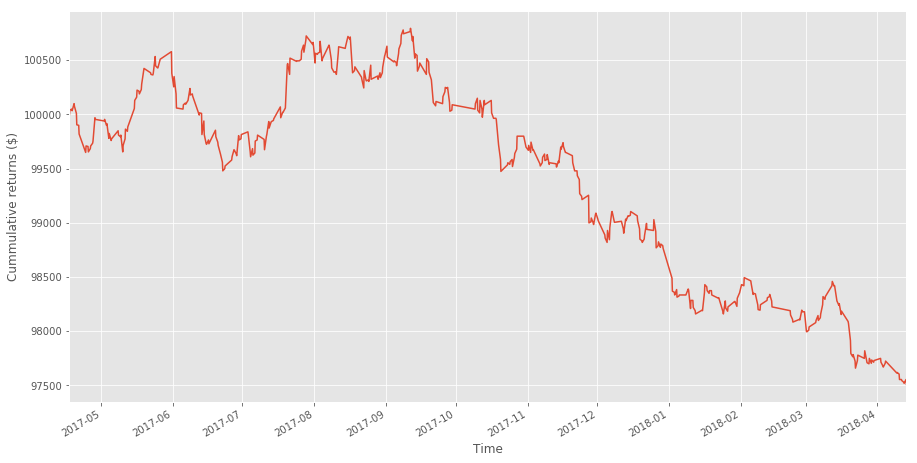

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting m9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\m9000_4h.csv
file asset start date:  2004/09/23 08:00
majority:0, length: 767; minority:1, length: 700
-----------------------------------------------
X length:  1534
X_val length:  726
X_train length:  1278
X_test length:  256
-----------------------------------------------
y length:  1534
y_val length:  726
y_train length: 1278
y_test length: 256
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 67.99 %
F1 Score: 0.6685
Area Under ROC Curve Score: 0.6799
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 48.21 %
F1 Score: 0.4849
Area Under ROC Curve Score: 0.4834
----------------------------------------------------


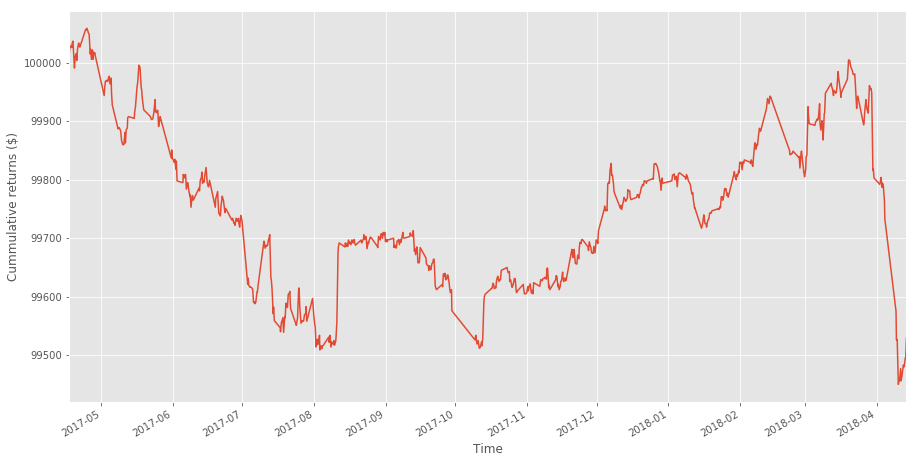

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting OI000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\OI000_4h.csv
file asset start date:  2012/09/20 08:00
majority:0, length: 720; minority:1, length: 693
-----------------------------------------------
X length:  1440
X_val length:  725
X_train length:  1200
X_test length:  240
-----------------------------------------------
y length:  1440
y_val length:  725
y_train length: 1200
y_test length: 240


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 65.00 %
F1 Score: 0.6684
Area Under ROC Curve Score: 0.6500
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.00 %
F1 Score: 0.5153
Area Under ROC Curve Score: 0.5201
----------------------------------------------------


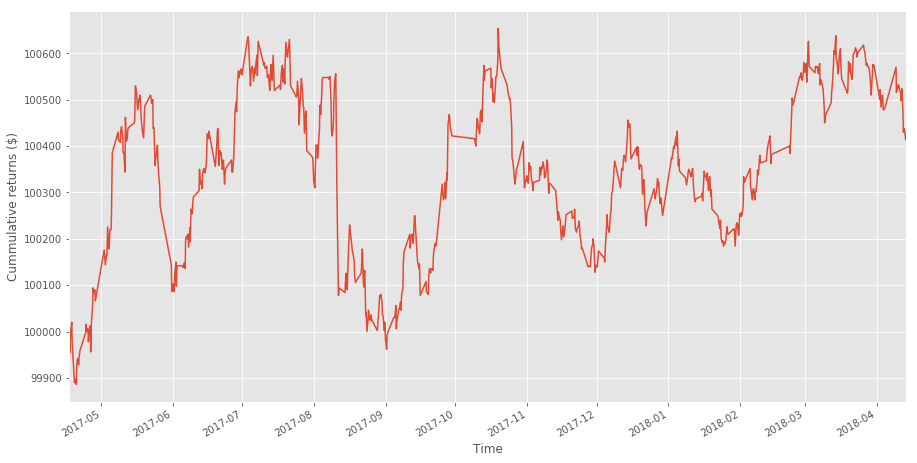

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting T9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\T9000_4h.csv
file asset start date:  2015/03/20 08:00
majority:1, length: 495; minority:0, length: 483
-----------------------------------------------
X length:  990
X_val length:  488
X_train length:  825
X_test length:  165
-----------------------------------------------
y length:  990
y_val length:  488
y_train length: 825
y_test length: 165
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 67.68 %
F1 Score: 0.6559
Area Under ROC Curve Score: 0.6768
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.20 %
F1 Score: 0.4659
Area Under ROC Curve Score: 0.4998
----------------------------------------------------


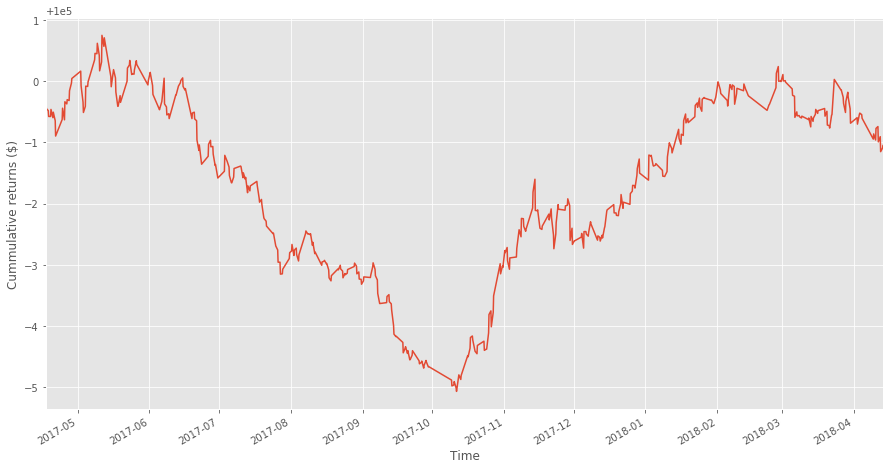

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
    accuracy  backtest commodity  max_depth  min_samples_split   n  \
0   0.517098         1     au000         50                 10  10   
1   0.522541         2     IC000         50                 10  10   
2   0.515152         3     j9000         50                 10  10   
3   0.512295         4     l9000         50                 10  10   
4   0.479339         5     m9000         50                 10  10   
5   0.526897         6     OI000         50                 10  10   
6   0.481557         7     T9000         50                 10  10   
7   0.529534         8     au000        100                 10  10   
8   0.512295         9     IC000        100                 10  10   
9   0.516529        10     j9000        100                 10 

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1966
X_val length:  695
X_train length:  1638
X_test length:  328
-----------------------------------------------
y length:  1966
y_val length:  695
y_train length: 1638
y_test length: 328
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 68.41 %
F1 Score: 0.6590
Area Under ROC Curve Score: 0.6841
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 46.62 %
F1 Score: 0.3091
Area Under ROC Curve Score: 0.4519
----------------------------------------------------


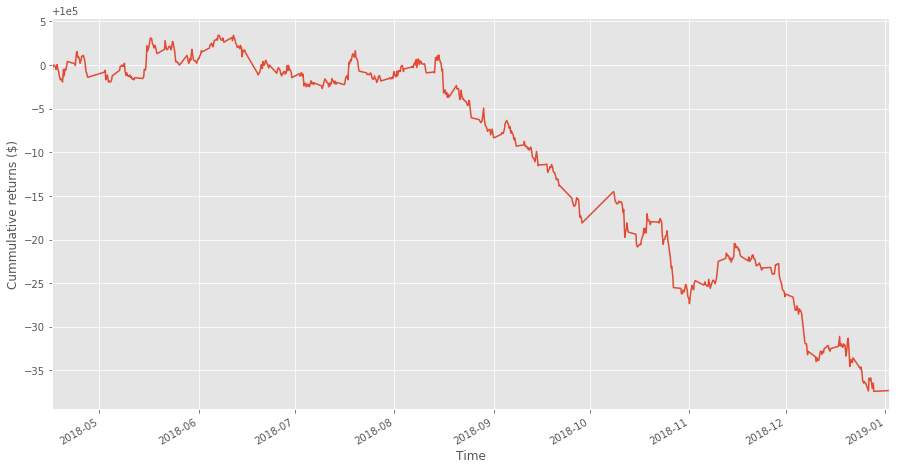

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting IC000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\IC000_4h.csv
file asset start date:  2015/04/15 08:00
majority:1, length: 491; minority:0, length: 483
-----------------------------------------------
X length:  982
X_val length:  372
X_train length:  818
X_test length:  164
-----------------------------------------------
y length:  982
y_val length:  372
y_train length: 818
y_test length: 164
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 72.20 %
F1 Score: 0.7347
Area Under ROC Curve Score: 0.7220
------------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



validation datasets performance: 
Accuracy Score: 51.34 %
F1 Score: 0.5147
Area Under ROC Curve Score: 0.5225
----------------------------------------------------


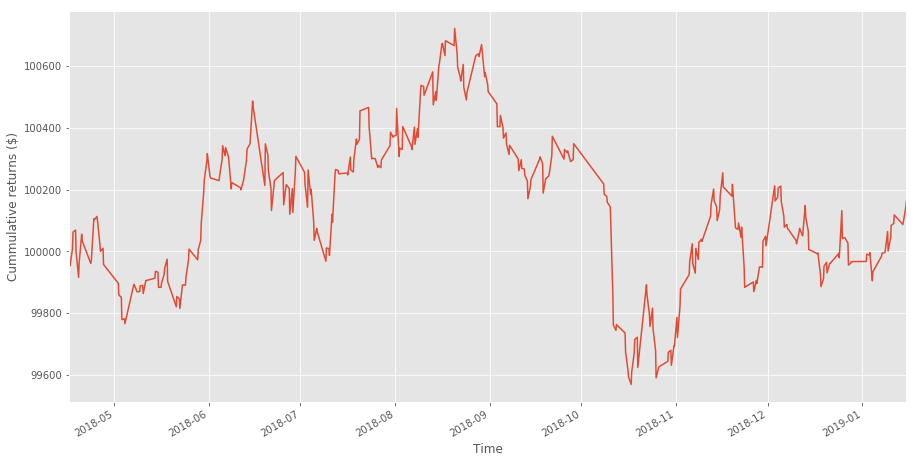

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting j9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\j9000_4h.csv
file asset start date:  2011/04/15 08:00
majority:1, length: 761; minority:0, length: 686
-----------------------------------------------
X length:  1522
X_val length:  524
X_train length:  1268
X_test length:  254
-----------------------------------------------
y length:  1522
y_val length:  524
y_train length: 1268
y_test length: 254
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 72.01 %
F1 Score: 0.7058
Area Under ROC Curve Score: 0.7201
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 50.00 %
F1 Score: 0.5201
Area Under ROC Curve Score: 0.4998
----------------------------------------------------


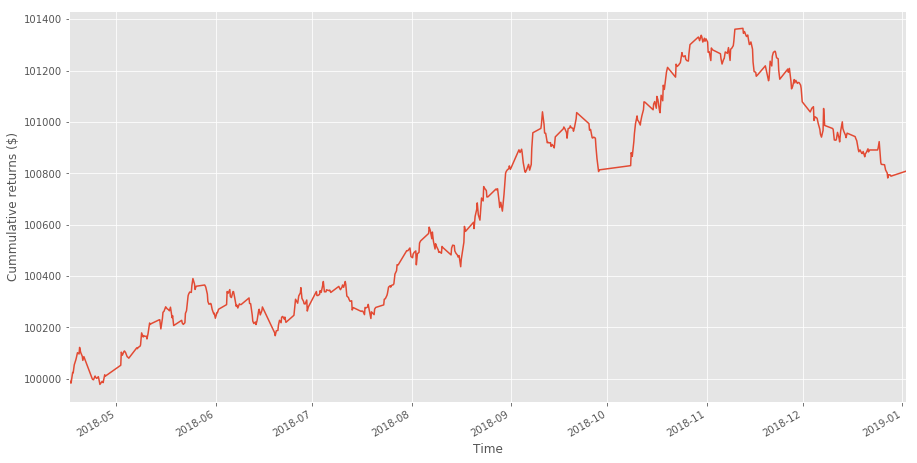

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting l9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\l9000_4h.csv
file asset start date:  2007/07/31 08:00
majority:0, length: 504; minority:1, length: 470
-----------------------------------------------
X length:  1008
X_val length:  372
X_train length:  840
X_test length:  168
-----------------------------------------------
y length:  1008
y_val length:  372
y_train length: 840
y_test length: 168
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 68.65 %
F1 Score: 0.6973
Area Under ROC Curve Score: 0.6865
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 53.23 %
F1 Score: 0.5272
Area Under ROC Curve Score: 0.5323
----------------------------------------------------


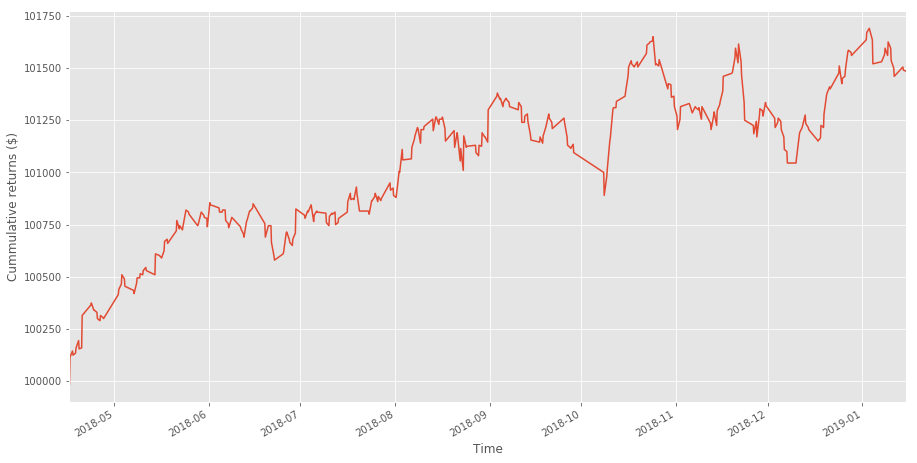

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting m9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\m9000_4h.csv
file asset start date:  2004/09/23 08:00
majority:0, length: 751; minority:1, length: 696


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1502
X_val length:  553
X_train length:  1251
X_test length:  251
-----------------------------------------------
y length:  1502
y_val length:  553
y_train length: 1251
y_test length: 251
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 72.37 %
F1 Score: 0.7140
Area Under ROC Curve Score: 0.7237
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 49.91 %
F1 Score: 0.4861
Area Under ROC Curve Score: 0.4996
----------------------------------------------------


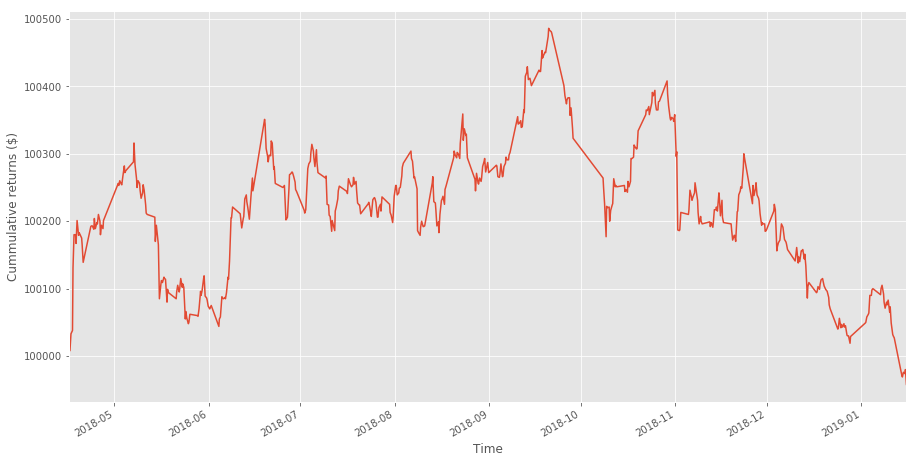

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting OI000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\OI000_4h.csv
file asset start date:  2012/09/20 08:00
majority:0, length: 730; minority:1, length: 717
-----------------------------------------------
X length:  1460
X_val length:  553
X_train length:  1216
X_test length:  244
-----------------------------------------------
y length:  1460
y_val length:  553
y_train length: 1216
y_test length: 244
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 70.75 %
F1 Score: 0.7117
Area Under ROC Curve Score: 0.7075
--------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


validation datasets performance: 
Accuracy Score: 53.16 %
F1 Score: 0.5029
Area Under ROC Curve Score: 0.5310
----------------------------------------------------


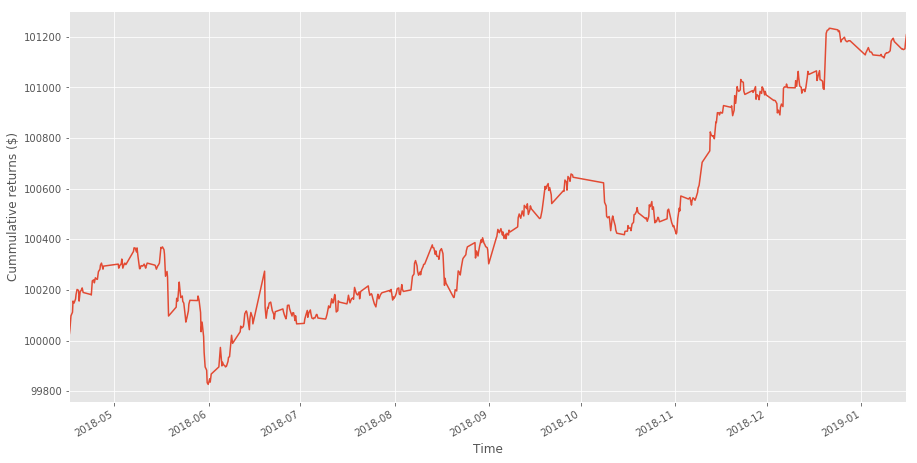

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting T9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\T9000_4h.csv
file asset start date:  2015/03/20 08:00
majority:0, length: 503; minority:1, length: 471
-----------------------------------------------
X length:  1006
X_val length:  372
X_train length:  838
X_test length:  168
-----------------------------------------------
y length:  1006
y_val length:  372
y_train length: 838
y_test length: 168
-----------------------------------------------
train_test datasets performance: 

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Accuracy Score: 72.27 %
F1 Score: 0.7213
Area Under ROC Curve Score: 0.7227
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 48.12 %
F1 Score: 0.4798
Area Under ROC Curve Score: 0.4837
----------------------------------------------------


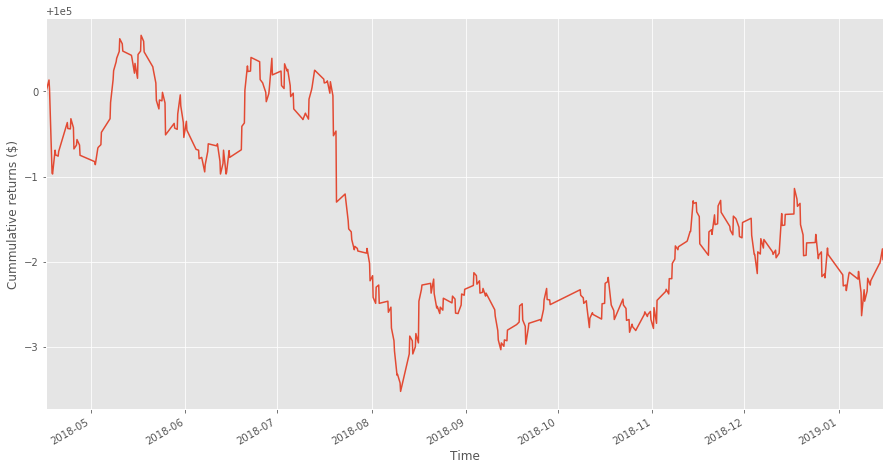

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting au000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\au000_4h.csv
file asset start date:  2008-1-9 8:00
majority:0, length: 983; minority:1, length: 940


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1966
X_val length:  695
X_train length:  1638
X_test length:  328
-----------------------------------------------
y length:  1966
y_val length:  695
y_train length: 1638
y_test length: 328
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 62.97 %
F1 Score: 0.6061
Area Under ROC Curve Score: 0.6297
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 47.77 %
F1 Score: 0.3774
Area Under ROC Curve Score: 0.4684
----------------------------------------------------


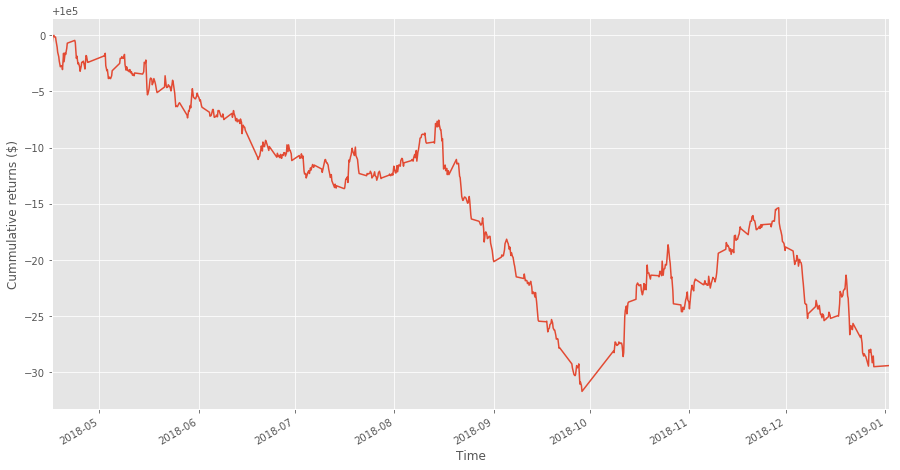

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting IC000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\IC000_4h.csv
file asset start date:  2015/04/15 08:00
majority:1, length: 491; minority:0, length: 483
-----------------------------------------------
X length:  982
X_val length:  372
X_train length:  818
X_test length:  164
-----------------------------------------------
y length:  982
y_val length:  372
y_train length: 818
y_test length: 164
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 69.55 %
F1 Score: 0.7139
Area Under ROC Curve Score: 0.6955
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 49.46 %
F1 Score: 0.5155
Area Under ROC Curve Score: 0.5086
----------------------------------------------------


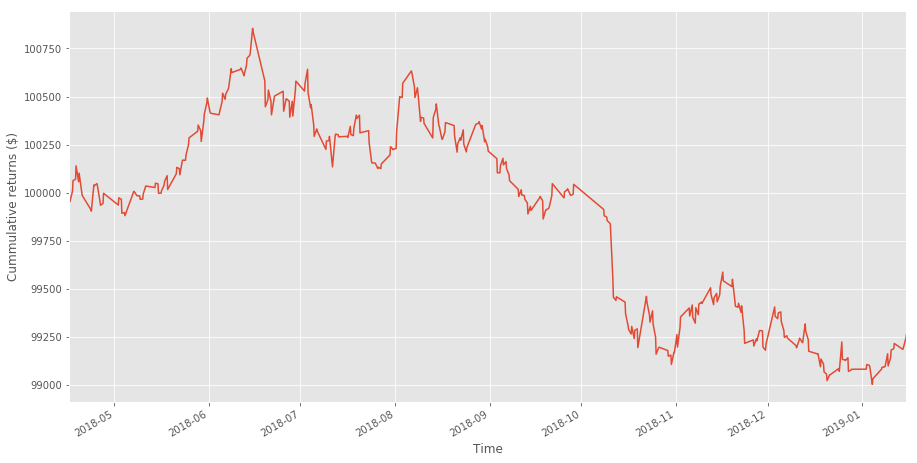

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting j9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\j9000_4h.csv
file asset start date:  2011/04/15 08:00
majority:1, length: 761; minority:0, length: 686


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-----------------------------------------------
X length:  1522
X_val length:  524
X_train length:  1268
X_test length:  254
-----------------------------------------------
y length:  1522
y_val length:  524
y_train length: 1268
y_test length: 254
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 67.28 %
F1 Score: 0.6626
Area Under ROC Curve Score: 0.6728
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 48.85 %
F1 Score: 0.5127
Area Under ROC Curve Score: 0.4884
----------------------------------------------------


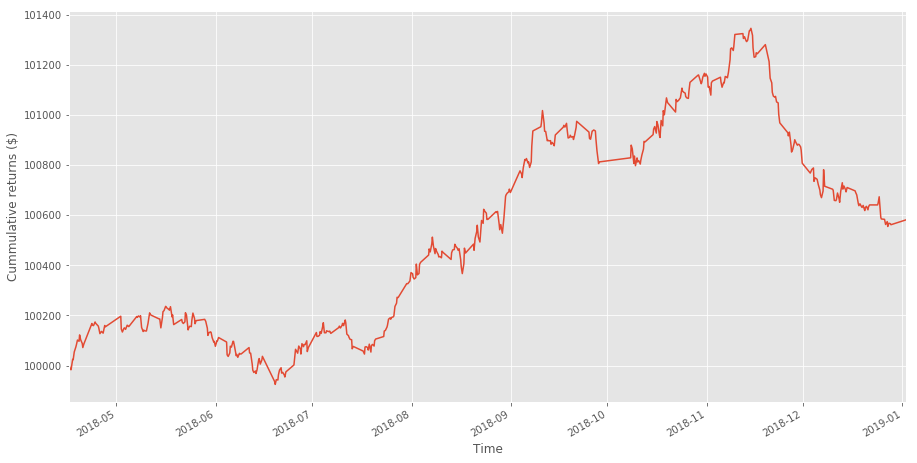

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting l9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\l9000_4h.csv
file asset start date:  2007/07/31 08:00
majority:0, length: 504; minority:1, length: 470
-----------------------------------------------
X length:  1008
X_val length:  372
X_train length:  840
X_test length:  168

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-----------------------------------------------
y length:  1008
y_val length:  372
y_train length: 840
y_test length: 168
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 64.68 %
F1 Score: 0.6622
Area Under ROC Curve Score: 0.6468
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 52.96 %
F1 Score: 0.5283
Area Under ROC Curve Score: 0.5298
----------------------------------------------------


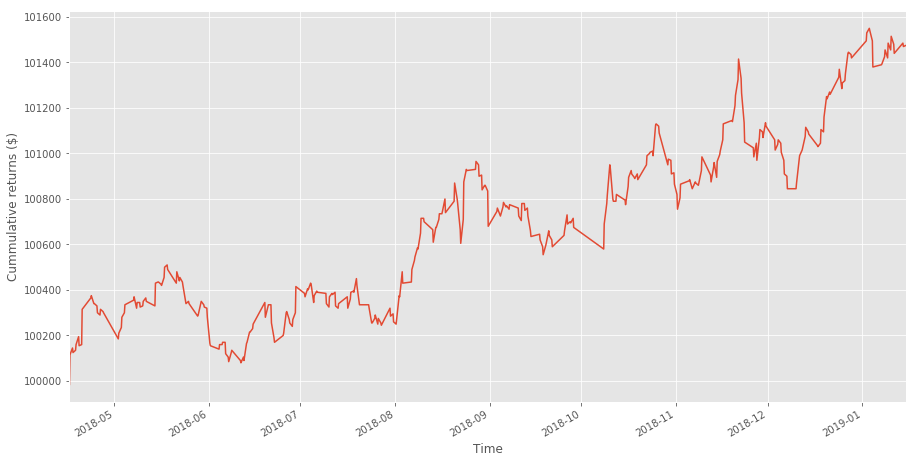

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting m9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\m9000_4h.csv
file asset start date:  2004/09/23 08:00
majority:0, length: 751; minority:1, length: 696
-----------------------------------------------
X length:  1502
X_val length:  553
X_train length:  1251
X_test length:  251
-----------------------------------------------
y length:  1502
y_val length:  553
y_train length: 1251
y_test length: 251
-----------------------------------------------


C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_test datasets performance: 
Accuracy Score: 70.31 %
F1 Score: 0.6962
Area Under ROC Curve Score: 0.7031
----------------------------------------------------
validation datasets performance: 
Accuracy Score: 48.28 %
F1 Score: 0.4325
Area Under ROC Curve Score: 0.4790
----------------------------------------------------


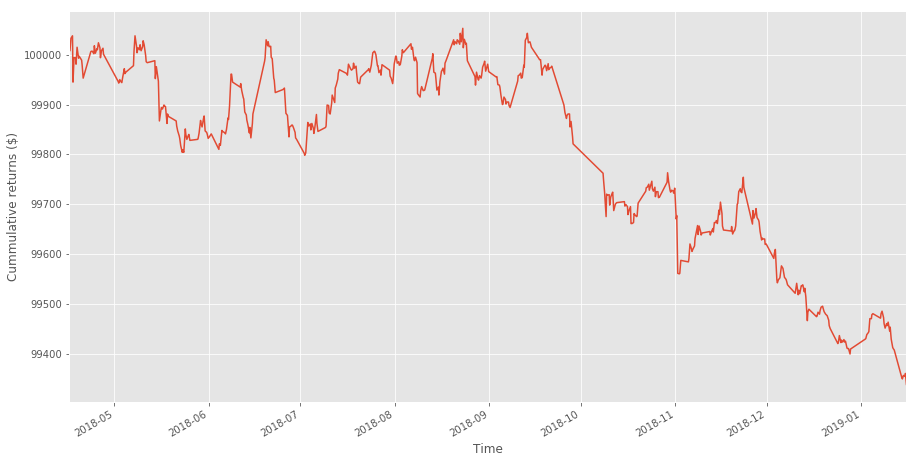

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting OI000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\OI000_4h.csv
file asset start date:  2012/09/20 08:00
majority:0, length: 730; minority:1, length: 717
-----------------------------------------------
X length:  1460
X_val length:  553
X_train length:  1216
X_test length:  244
-----------------------------------------------
y length:  1460
y_val length:  553
y_train length: 1216
y_test length: 244
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 66.44 %
F1 Score: 0.6746
Area Under ROC Curve Score: 0.6644
--------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


validation datasets performance: 
Accuracy Score: 51.36 %
F1 Score: 0.5118
Area Under ROC Curve Score: 0.5136
----------------------------------------------------


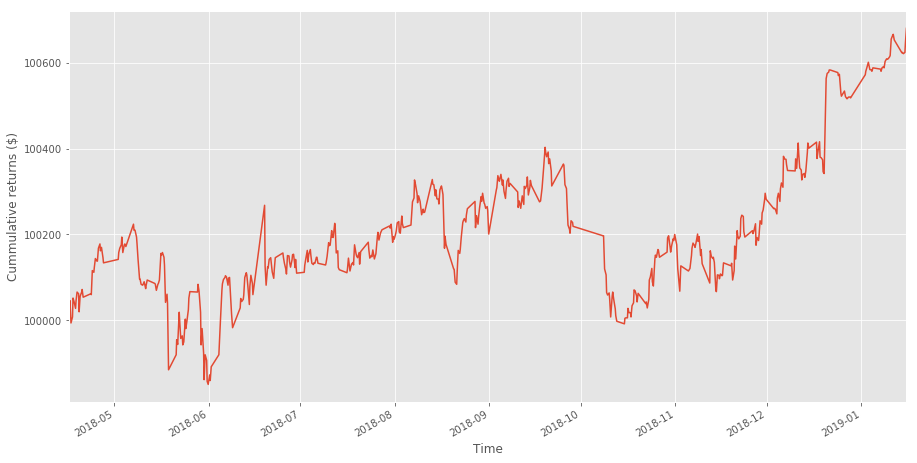

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
=====================================Start backtesting T9000=====================================
Creating ML_Models...
file:  C:/Users/workspace/brad_public_workspace_on_win/SH_tongliang/data/commodities_data/1_17_2019_4h_commodities_data\T9000_4h.csv
file asset start date:  2015/03/20 08:00
majority:0, length: 503; minority:1, length: 471
-----------------------------------------------
X length:  1006
X_val length:  372
X_train length:  838
X_test length:  168
-----------------------------------------------
y length:  1006
y_val length:  372
y_train length: 838
y_test length: 168
-----------------------------------------------
train_test datasets performance: 
Accuracy Score: 66.40 %
F1 Score: 0.6579
Area Under ROC Curve Score: 0.6640
----------------

C:\Users\Brad Sun\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


validation datasets performance: 
Accuracy Score: 50.54 %
F1 Score: 0.4973
Area Under ROC Curve Score: 0.5090
----------------------------------------------------


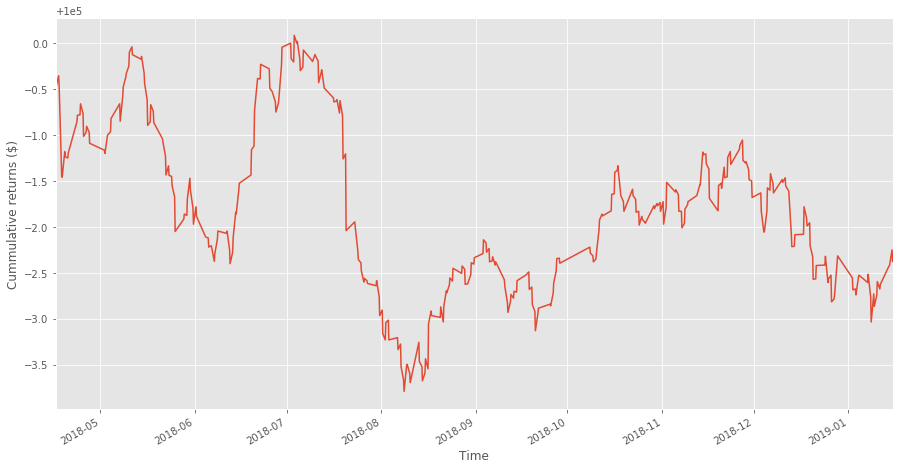

=============================================All Finished.==================================================
Processing signal dataframe...
Processing original OHLCV dataframe...
Merging signal dataframe and OHLCV dataframe...
All done!
    accuracy  backtest commodity  max_depth  min_samples_split   n  \
0   0.517098         1     au000         50                 10  10   
1   0.522541         2     IC000         50                 10  10   
2   0.515152         3     j9000         50                 10  10   
3   0.512295         4     l9000         50                 10  10   
4   0.479339         5     m9000         50                 10  10   
5   0.526897         6     OI000         50                 10  10   
6   0.481557         7     T9000         50                 10  10   
7   0.529534         8     au000        100                 10  10   
8   0.512295         9     IC000        100                 10  10   
9   0.516529        10     j9000        100                 10 

In [12]:
accuracy_list = []
backtest_curves_list = []

for ttv in ttv_split_dict.keys():
    print ("Running AIO backtests for periods: ", ttv_split_dict[ttv])
    tt_start = ttv_split_dict[ttv]['tt_start']
    tt_end = ttv_split_dict[ttv]['tt_end']
    val_end = ttv_split_dict[ttv]['val_end']
    backtest_records, backtest_curves, df_bt = random_forest_run_backtests(rf_paras, 100000, 2, location, folder, rf_backtest_records, tt_start, tt_end, val_end)
    acc_mean = df_bt['accuracy'].mean()
    accuracy_list.append(acc_mean)
    backtest_curves_list.append(backtest_curves)

In [13]:
for i in range(len(backtest_curves_list)):
    print (i)

0
1


第1次验证集回测准确率：0.5038245967265312
第2次验证集回测准确率：0.5025899016874812
平均回测准确率： 0.5032072492070062


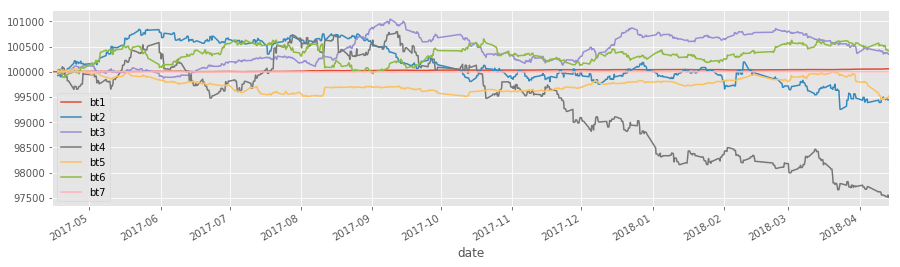

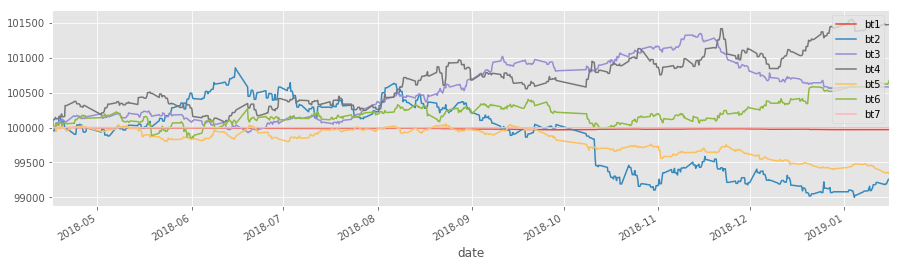

In [131]:
for i in range(len(backtest_curves_list)):
    backtest_curves_list[i].plot(figsize = (15, 4))
    print ("第{}次验证集回测准确率：{}".format(i+1, accuracy_list[i]))
print ("平均回测准确率：", np.mean(accuracy_list))